# Deep Learning Applications: Laboratory #1

In this first laboratory we will work relatively simple architectures to get a feel for working with Deep Models. This notebook is designed to work with PyTorch, but as I said in the introductory lecture: please feel free to use and experiment with whatever tools you like.

**Important Notes**:
1. Be sure to **document** all of your decisions, as well as your intermediate and final results. Make sure your conclusions and analyses are clearly presented. Don't make us dig into your code or walls of printed results to try to draw conclusions from your code.
2. If you use code from someone else (e.g. Github, Stack Overflow, ChatGPT, etc) you **must be transparent about it**. Document your sources and explain how you adapted any partial solutions to creat **your** solution.



## Exercise 1: Warming Up
In this series of exercises I want you to try to duplicate (on a small scale) the results of the ResNet paper:

> [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385), Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun, CVPR 2016.

We will do this in steps using a Multilayer Perceptron on MNIST.

Recall that the main message of the ResNet paper is that **deeper** networks do not **guarantee** more reduction in training loss (or in validation accuracy). Below you will incrementally build a sequence of experiments to verify this for an MLP. A few guidelines:

+ I have provided some **starter** code at the beginning. **NONE** of this code should survive in your solutions. Not only is it **very** badly written, it is also written in my functional style that also obfuscates what it's doing (in part to **discourage** your reuse!). It's just to get you *started*.
+ These exercises ask you to compare **multiple** training runs, so it is **really** important that you factor this into your **pipeline**. Using [Tensorboard](https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html) is a **very** good idea -- or, even better [Weights and Biases](https://wandb.ai/site).
+ You may work and submit your solutions in **groups of at most two**. Share your ideas with everyone, but the solutions you submit *must be your own*.

First some boilerplate to get you started, then on to the actual exercises!

### Preface: Some code to get you started

What follows is some **very simple** code for training an MLP on MNIST. The point of this code is to get you up and running (and to verify that your Python environment has all needed dependencies).

**Note**: As you read through my code and execute it, this would be a good time to think about *abstracting* **your** model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

In [1]:
import torch

print(torch.__version__)




2.5.1


In [2]:
# Start with some standard imports.
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import torch
from torchvision.datasets import MNIST, CIFAR10
from torch.utils.data import Subset
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import wandb

#### Data preparation

Here is some basic dataset loading, validation splitting code to get you started working with MNIST.

In [3]:
# Standard MNIST transform.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST train and test.
ds_train = MNIST(root='./data', train=True, download=True, transform=transform)
ds_test = MNIST(root='./data', train=False, download=True, transform=transform)

# Split train into train and validation.
val_size = 5000
I = np.random.permutation(len(ds_train))
ds_val = Subset(ds_train, I[:val_size])
ds_train = Subset(ds_train, I[val_size:])

#### Boilerplate training and evaluation code

This is some **very** rough training, evaluation, and plotting code. Again, just to get you started. I will be *very* disappointed if any of this code makes it into your final submission.

In [7]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report

# Function to train a model for a single epoch over the data loader.
def train_epoch(model, dl, opt, epoch='Unknown', device='cpu'):
    model.train()
    losses = []
    for (xs, ys) in tqdm(dl, desc=f'Training epoch {epoch}', leave=True):
        xs = xs.to(device)
        ys = ys.to(device)
        opt.zero_grad()
        logits = model(xs)
        loss = F.cross_entropy(logits, ys)
        loss.backward()
        opt.step()
        losses.append(loss.item())
    return np.mean(losses)

# Function to evaluate model over all samples in the data loader.
def evaluate_model(model, dl, device='cpu'):
    model.eval()
    predictions = []
    gts = []
    for (xs, ys) in tqdm(dl, desc='Evaluating', leave=False):
        xs = xs.to(device)
        preds = torch.argmax(model(xs), dim=1)
        gts.append(ys)
        predictions.append(preds.detach().cpu().numpy())
        
    # Return accuracy score and classification report.
    return (accuracy_score(np.hstack(gts), np.hstack(predictions)),
            classification_report(np.hstack(gts), np.hstack(predictions), zero_division=0, digits=3))

# Simple function to plot the loss curve and validation accuracy.
def plot_validation_curves(losses_and_accs):
    losses = [x for (x, _) in losses_and_accs]
    accs = [x for (_, x) in losses_and_accs]
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Average Training Loss per Epoch')
    plt.subplot(1, 2, 2)
    plt.plot(accs)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.title(f'Best Accuracy = {np.max(accs)} @ epoch {np.argmax(accs)}')

#### A basic, parameterized MLP

This is a very basic implementation of a Multilayer Perceptron. Don't waste too much time trying to figure out how it works -- the important detail is that it allows you to pass in a list of input, hidden layer, and output *widths*. **Your** implementation should also support this for the exercises to come.

In [4]:
class MLP(nn.Module):
    def __init__(self, layer_sizes):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(nin, nout) for (nin, nout) in zip(layer_sizes[:-1], layer_sizes[1:])])
    
    def forward(self, x):
        return reduce(lambda f, g: lambda x: g(F.relu(f(x))), self.layers, lambda x: x.flatten(1))(x)

print(MLP([784, 100, 10]))

MLP(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=10, bias=True)
  )
)


#### A *very* minimal training pipeline.

Here is some basic training and evaluation code to get you started.

**Important**: I cannot stress enough that this is a **terrible** example of how to implement a training pipeline. You can do better!

Training epoch 99: 100%|██████████| 430/430 [00:02<00:00, 165.61it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

           0      0.962     0.980     0.971       980
           1      0.971     0.980     0.975      1135
           2      0.948     0.943     0.946      1032
           3      0.919     0.938     0.928      1010
           4      0.944     0.952     0.948       982
           5      0.938     0.916     0.927       892
           6      0.955     0.961     0.958       958
           7      0.958     0.951     0.955      1028
           8      0.937     0.922     0.930       974
           9      0.948     0.937     0.942      1009

    accuracy                          0.949     10000
   macro avg      0.948     0.948     0.948     10000
weighted avg      0.949     0.949     0.949     10000



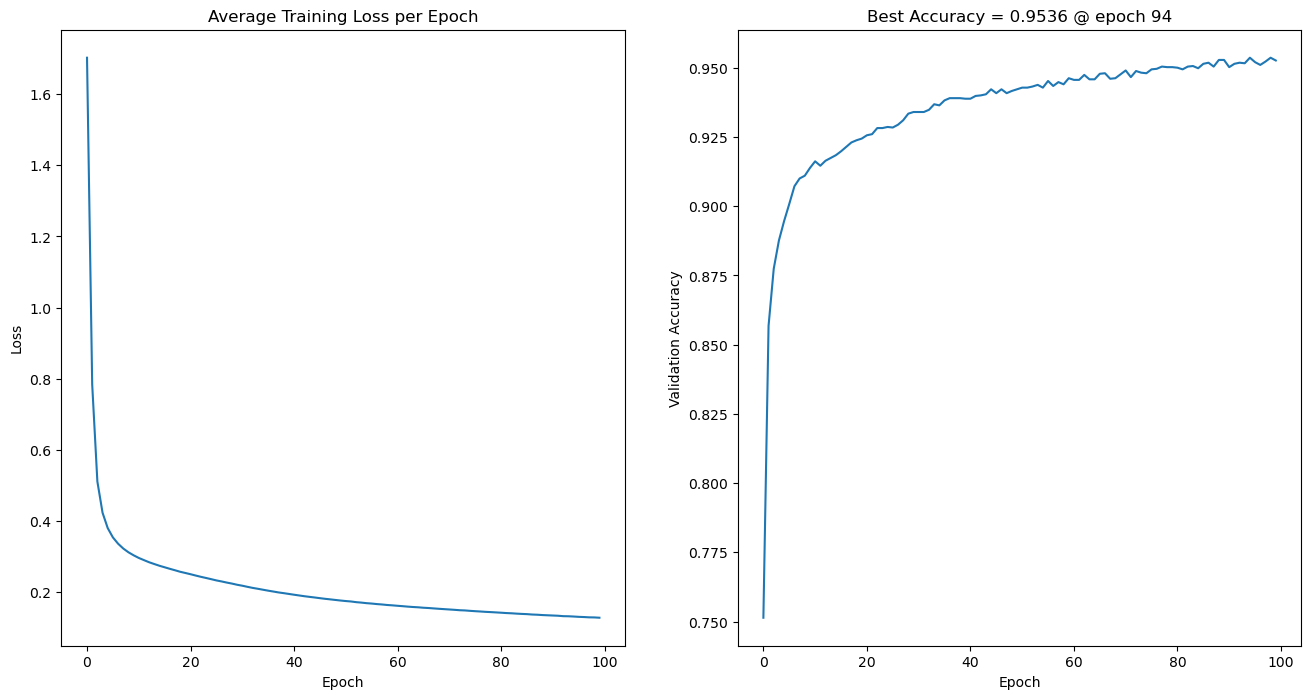

In [9]:
# Training hyperparameters.
device = 'cuda' if torch.cuda.is_available else 'cpu'
epochs = 100
lr = 0.0001
batch_size = 128

# Architecture hyperparameters.
input_size = 28*28
width = 16
depth = 2

# Dataloaders.
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=True, num_workers=4)
dl_val   = torch.utils.data.DataLoader(ds_val, batch_size, num_workers=4)
dl_test  = torch.utils.data.DataLoader(ds_test, batch_size, shuffle=True, num_workers=4)

# Instantiate model and optimizer.
model_mlp = MLP([input_size] + [width]*depth + [10]).to(device)
opt = torch.optim.Adam(params=model_mlp.parameters(), lr=lr)

# Training loop.
losses_and_accs = []
for epoch in range(epochs):
    loss = train_epoch(model_mlp, dl_train, opt, epoch, device=device)
    (val_acc, _) = evaluate_model(model_mlp, dl_val, device=device)
    losses_and_accs.append((loss, val_acc))

# And finally plot the curves.
plot_validation_curves(losses_and_accs)
print(f'Accuracy report on TEST:\n {evaluate_model(model_mlp, dl_test, device=device)[1]}')

### Exercise 1.1: A baseline MLP

Implement a *simple* Multilayer Perceptron to classify the 10 digits of MNIST (e.g. two *narrow* layers). Use my code above as inspiration, but implement your own training pipeline -- you will need it later. Train this model to convergence, monitoring (at least) the loss and accuracy on the training and validation sets for every epoch. Below I include a basic implementation to get you started -- remember that you should write your *own* pipeline!

**Note**: This would be a good time to think about *abstracting* your model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

**Important**: Given the *many* runs you will need to do, and the need to *compare* performance between them, this would **also** be a great point to study how **Tensorboard** or **Weights and Biases** can be used for performance monitoring.

In [ ]:
class my_MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(my_MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.flatten(1) # MLP requires a 1D input
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    

In [ ]:
def train(model, train_loader, val_loader, num_epochs, criterion, optimizer, device):
    train_losses = []
    val_accuracies = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()

            plot_gradient_magnitude(model)  # Plot gradient magnitudes before optimizer step
            plt.title(f'Gradient Magnitudes at Epoch {epoch + 1}, Batch {batch_idx + 1}')
            plt.show()

            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        (val_acc, val_loss, _) = evaluate(model, val_loader, device, criterion)
        val_accuracies.append(val_acc)
        val_losses.append(val_loss)
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            #"train_accuracy": train_acc,
            "val_loss": val_loss,
            "val_accuracy": val_acc,
            "learning_rate": optimizer.param_groups[0]['lr']
        })
        print(f'Epoch {epoch}: Train Loss: {train_loss:.4f}, Val Acc: {val_acc:.2f}%')

    
    return train_losses, val_accuracies, val_losses
    
def evaluate(model, data_loader, device, criterion=None, log_wandb=False):
    model.eval()
    predictions = []
    gts = []
    class_names = [str(i) for i in range(10)]
    total_loss = 0.0
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            if criterion is not None:
                loss = criterion(output, target)
                total_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            predictions.extend(predicted.cpu().numpy())
            gts.extend(target.cpu().numpy())
    accuracy = accuracy_score(gts, predictions)*100
    if criterion is not None:
        avg_loss = total_loss / len(data_loader)
        wandb.log({
            "val_loss": avg_loss
        })
    else:
        avg_loss = None

    report = classification_report(gts, predictions, zero_division=0, digits=3)
    wandb.log({
        "classification_report": report
    })
    wandb.log({
        "confusion_matrix": wandb.plot.confusion_matrix(
            preds=predictions,
            y_true=gts,
            class_names=class_names
        )
    })
    return accuracy, avg_loss, report

def plot_training_metrics(train_losses, val_accuracies, val_losses=None, save_path=None, model_name=None, model_depth=None):
    epochs = range(1, len(train_losses) + 1)
    
    # Crea subplots
    if val_losses is not None:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    else:

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    if model_name is not None:
        # Plot 1: Training Loss
        ax1.plot(epochs, train_losses, 'b-', label=f'Training Loss ({model_name}, Depth ({model_depth}))', linewidth=2)
        ax1.set_title('Training Loss', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.grid(True, alpha=0.3)
        ax1.legend()

        # Plot 2: Validation Accuracy
        ax2.plot(epochs, val_accuracies, 'g-', label=f'Validation Accuracy ({model_name}, Depth ({model_depth}))', linewidth=2)
        ax2.set_title('Validation Accuracy', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.grid(True, alpha=0.3)
        ax2.legend()

        # Plot 3: Validation Loss (se fornita)
        if val_losses is not None:
            ax3.plot(epochs, val_losses, 'r-', label=f'Validation Loss ({model_name}, Depth ({model_depth}))', linewidth=2)
            ax3.set_title('Validation Loss', fontsize=14, fontweight='bold')
            ax3.set_xlabel('Epoch')
            ax3.set_ylabel('Loss')
            ax3.grid(True, alpha=0.3)
            ax3.legend()

    else:
        ax1.plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2)
        ax1.set_title('Training Loss', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.grid(True, alpha=0.3)
        ax1.legend()

        # Plot 2: Validation Accuracy
        ax2.plot(epochs, val_accuracies, 'g-', label='Validation Accuracy', linewidth=2)
        ax2.set_title('Validation Accuracy', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.grid(True, alpha=0.3)
        ax2.legend()

            # Plot 3: Validation Loss (se fornita)
        if val_losses is not None:
            ax3.plot(epochs, val_losses, 'r-', label='Validation Loss', linewidth=2)
            ax3.set_title('Validation Loss', fontsize=14, fontweight='bold')
            ax3.set_xlabel('Epoch')
            ax3.set_ylabel('Loss')
            ax3.grid(True, alpha=0.3)
            ax3.legend()

    plt.tight_layout()
    
    # Salva se richiesto
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot salvato in: {save_path}")
    
    plt.show()

def plot_gradient_magnitude(model, wandb_log=True):
    grad_magnitudes = []
    
    for name, param in model.named_parameters():
        if param.grad is not None:
            # Calcola la magnitudine del gradiente (norma L2)
            grad_magnitude = torch.norm(param.grad).item()
            grad_magnitudes.append((name, grad_magnitude))
    
    
    plt.figure(figsize=(12, 6))
    names = [x[0] for x in grad_magnitudes]
    magnitudes = [x[1] for x in grad_magnitudes]
    
    plt.bar(range(len(magnitudes)), magnitudes)
    plt.xticks(range(len(magnitudes)), names, rotation=45, ha='right')
    plt.yscale('log')  # Scala logaritmica per visualizzare meglio
    plt.ylabel('Gradient Magnitude (L2 norm)')
    plt.xlabel('Layer')
    plt.title('Gradient Magnitudes Across Layers')
    plt.tight_layout()
    if wandb_log:
        wandb.log({"gradient_magnitudes": wandb.Image(plt)})
    plt.show()

In [ ]:
# da vedere se includere questa funzione o se basta quello che già c'è

def plot_model_stats(model, wandb_log=True):
    # Gradients
    grad_magnitudes = []
    # Weights
    weight_magnitudes = []
    # Biases 
    bias_magnitudes = []
    
    for name, param in model.named_parameters():
        if 'weight' in name:
            weight_magnitudes.append((name, torch.norm(param.data).item()))
            if param.grad is not None:
                grad_magnitudes.append((name, torch.norm(param.grad).item()))
        elif 'bias' in name:
            bias_magnitudes.append((name, torch.norm(param.data).item()))
    
    # Create subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    
    # Plot gradients
    names = [x[0] for x in grad_magnitudes]
    magnitudes = [x[1] for x in grad_magnitudes]
    ax1.bar(range(len(magnitudes)), magnitudes)
    ax1.set_xticks(range(len(magnitudes)))
    ax1.set_xticklabels(names, rotation=45, ha='right')
    ax1.set_yscale('log')
    ax1.set_ylabel('Gradient Magnitude (L2 norm)')
    ax1.set_xlabel('Layer')
    ax1.set_title('Gradient Magnitudes')
    
    # Plot weights
    names = [x[0] for x in weight_magnitudes]
    magnitudes = [x[1] for x in weight_magnitudes]
    ax2.bar(range(len(magnitudes)), magnitudes)
    ax2.set_xticks(range(len(magnitudes)))
    ax2.set_xticklabels(names, rotation=45, ha='right')
    ax2.set_yscale('log')
    ax2.set_ylabel('Weight Magnitude (L2 norm)')
    ax2.set_xlabel('Layer')
    ax2.set_title('Weight Magnitudes')
    
    # Plot biases
    names = [x[0] for x in bias_magnitudes]
    magnitudes = [x[1] for x in bias_magnitudes]
    ax3.bar(range(len(magnitudes)), magnitudes)
    ax3.set_xticks(range(len(magnitudes)))
    ax3.set_xticklabels(names, rotation=45, ha='right')
    ax3.set_yscale('log')
    ax3.set_ylabel('Bias Magnitude (L2 norm)')
    ax3.set_xlabel('Layer')
    ax3.set_title('Bias Magnitudes')
    
    plt.tight_layout()
    
    if wandb_log:
        # Log singole magnitudini
        stats = {}
        for name, mag in grad_magnitudes:
            stats[f"gradient/{name}"] = mag
        for name, mag in weight_magnitudes:
            stats[f"weight/{name}"] = mag
        for name, mag in bias_magnitudes:
            stats[f"bias/{name}"] = mag
            
        wandb.log(stats)
        wandb.log({"model_stats": wandb.Image(plt)})
    
    plt.show()

In [7]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
batch_size = 128
epochs = 100
input_size = 28*28
num_classes = 10
# Dataloaders.
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=True, num_workers=4)
dl_val   = torch.utils.data.DataLoader(ds_val, batch_size, num_workers=4)
dl_test  = torch.utils.data.DataLoader(ds_test, batch_size, shuffle=True, num_workers=4)

criterion = nn.CrossEntropyLoss()

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
lr = 0.0001

hidden_size = 16

model_my_MLP = my_MLP(input_size, hidden_size, num_classes).to(device)
optimizer = torch.optim.Adam(model_my_MLP.parameters(), lr=lr)

wandb.init(
    project="lab1",
    name="esercizio1",
    config={
        "epochs": 100,
        "learning_rate": 0.0001,
        "batch_size": 128,
        "input_size": 28*28,
        "hidden_size": 16,
        "num_classes": 10,
        "optimizer": "Adam",
        "loss_function": "CrossEntropyLoss"
    }
)

train_losses, val_accuracies, val_losses = train(model_my_MLP, dl_train, dl_val, epochs, criterion, optimizer, device)

plot_training_metrics(train_losses=train_losses,val_accuracies=val_accuracies, val_losses=val_losses)

CrossEntropyLoss()
Epoch 0: Train Loss: 1.3515, Val Acc: 83.50%
CrossEntropyLoss()
Epoch 1: Train Loss: 0.5826, Val Acc: 87.32%
CrossEntropyLoss()
Epoch 2: Train Loss: 0.4343, Val Acc: 88.68%
CrossEntropyLoss()
Epoch 3: Train Loss: 0.3762, Val Acc: 89.52%
CrossEntropyLoss()
Epoch 4: Train Loss: 0.3447, Val Acc: 90.08%
CrossEntropyLoss()
Epoch 5: Train Loss: 0.3241, Val Acc: 90.38%
CrossEntropyLoss()
Epoch 6: Train Loss: 0.3092, Val Acc: 90.78%
CrossEntropyLoss()
Epoch 7: Train Loss: 0.2982, Val Acc: 91.20%
CrossEntropyLoss()
Epoch 8: Train Loss: 0.2891, Val Acc: 91.44%
CrossEntropyLoss()
Epoch 9: Train Loss: 0.2815, Val Acc: 91.60%
CrossEntropyLoss()
Epoch 10: Train Loss: 0.2749, Val Acc: 91.86%
CrossEntropyLoss()
Epoch 11: Train Loss: 0.2690, Val Acc: 91.90%
CrossEntropyLoss()
Epoch 12: Train Loss: 0.2637, Val Acc: 92.02%
CrossEntropyLoss()
Epoch 13: Train Loss: 0.2588, Val Acc: 91.86%
CrossEntropyLoss()
Epoch 14: Train Loss: 0.2542, Val Acc: 92.08%
CrossEntropyLoss()
Epoch 15: Train 

In [17]:
wandb.init()
(accuracy, _, report) = evaluate(model_my_MLP, dl_test, device, log_wandb=True)

print(f'Test Accuracy: {accuracy:.2f}%')
print(f'\nClassification Report:\n{report}')
wandb.finish()

None


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Test Accuracy: 95.17%

Classification Report:
              precision    recall  f1-score   support

           0      0.965     0.982     0.973       980
           1      0.970     0.983     0.976      1135
           2      0.952     0.943     0.947      1032
           3      0.937     0.942     0.939      1010
           4      0.948     0.958     0.953       982
           5      0.937     0.934     0.935       892
           6      0.953     0.961     0.957       958
           7      0.960     0.958     0.959      1028
           8      0.931     0.918     0.925       974
           9      0.959     0.933     0.946      1009

    accuracy                          0.952     10000
   macro avg      0.951     0.951     0.951     10000
weighted avg      0.952     0.952     0.952     10000



classification_report,precis...


### Exercise 1.2: Adding Residual Connections

Implement a variant of your parameterized MLP network to support **residual** connections. Your network should be defined as a composition of **residual MLP** blocks that have one or more linear layers and add a skip connection from the block input to the output of the final linear layer.

**Compare** the performance (in training/validation loss and test accuracy) of your MLP and ResidualMLP for a range of depths. Verify that deeper networks **with** residual connections are easier to train than a network of the same depth **without** residual connections.

**For extra style points**: See if you can explain by analyzing the gradient magnitudes on a single training batch *why* this is the case. 

In [ ]:
# Your code here.
class My_Configurable_MLP(nn.Module):
    def __init__(self, input_size, hidden_layers_sizes, num_classes):
        super(My_Configurable_MLP, self).__init__()
        layers = []
        layer_input_size = input_size

        for layer_size in hidden_layers_sizes:
            layers.append(nn.Linear(layer_input_size, layer_size))
            layers.append(nn.ReLU())
            layer_input_size = layer_size
        layers.append(nn.Linear(layer_input_size, num_classes))
        self.network = nn.Sequential(*layers) # create the network

    def forward(self, x):
        x = x.flatten(1)
        return self.network(x)

class Residual_MLP(nn.Module):
    def __init__(self, input_size, hidden_layers_sizes, num_classes):
        super(Residual_MLP, self).__init__()

        if isinstance(hidden_layers_sizes, int):
            hidden_layers_sizes = [hidden_layers_sizes] * 2
        
        self.fc_input = nn.Linear(input_size, hidden_layers_sizes[0])
        self.residual_blocks = nn.ModuleList()
        self.projections = nn.ModuleList()

        layer_input_size = hidden_layers_sizes[0]
        for layer_size in hidden_layers_sizes[1:]:
            self.residual_blocks.append(nn.Linear(layer_input_size, layer_size))
            if layer_input_size != layer_size:
                self.projections.append(nn.Linear(layer_input_size, layer_size))
            else:
                self.projections.append(None)
            layer_input_size = layer_size
        
        self.fc_output = nn.Linear(hidden_layers_sizes[-1], num_classes)

    def forward(self, x):
        x = x.flatten(1)
        x = F.relu(self.fc_input(x))

        for residual_layer, projection in zip(self.residual_blocks, self.projections):
            residual = x
            x = F.relu(residual_layer(x))
            if projection is not None:
                residual = projection(residual)
            x = x + residual
        x=self.fc_output(x)
        
    
        return x

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
width = 16
lr = 0.0001
depth_values = [1, 3, 5, 8, 16, 24, 32] #3,

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Epoch 0: Train Loss: 1.4285, Val Acc: 81.54%
Epoch 1: Train Loss: 0.6446, Val Acc: 87.34%
Epoch 2: Train Loss: 0.4668, Val Acc: 89.52%
Epoch 3: Train Loss: 0.3923, Val Acc: 90.74%
Epoch 4: Train Loss: 0.3521, Val Acc: 91.40%
Epoch 5: Train Loss: 0.3266, Val Acc: 91.86%
Epoch 6: Train Loss: 0.3088, Val Acc: 92.10%
Epoch 7: Train Loss: 0.2940, Val Acc: 92.48%
Epoch 8: Train Loss: 0.2822, Val Acc: 92.52%
Epoch 9: Train Loss: 0.2727, Val Acc: 93.04%
Epoch 10: Train Loss: 0.2649, Val Acc: 93.14%
Epoch 11: Train Loss: 0.2582, Val Acc: 93.18%
Epoch 12: Train Loss: 0.2525, Val Acc: 93.34%
Epoch 13: Train Loss: 0.2472, Val Acc: 93.48%
Epoch 14: Train Loss: 0.2426, Val Acc: 93.62%
Epoch 15: Train Loss: 0.2386, Val Acc: 93.60%
Epoch 16: Train Loss: 0.2345, Val Acc: 93.82%
Epoch 17: Train Loss: 0.2309, Val Acc: 93.92%
Epoch 18: Train Loss: 0.2275, Val Acc: 93.66%
Epoch 19: Train Loss: 0.2248, Val Acc: 93.82%
Epoch 20: Train Loss: 0.2218, Val Acc: 93.86%
Epoch 21: Train Loss: 0.2189, Val Acc: 93.98

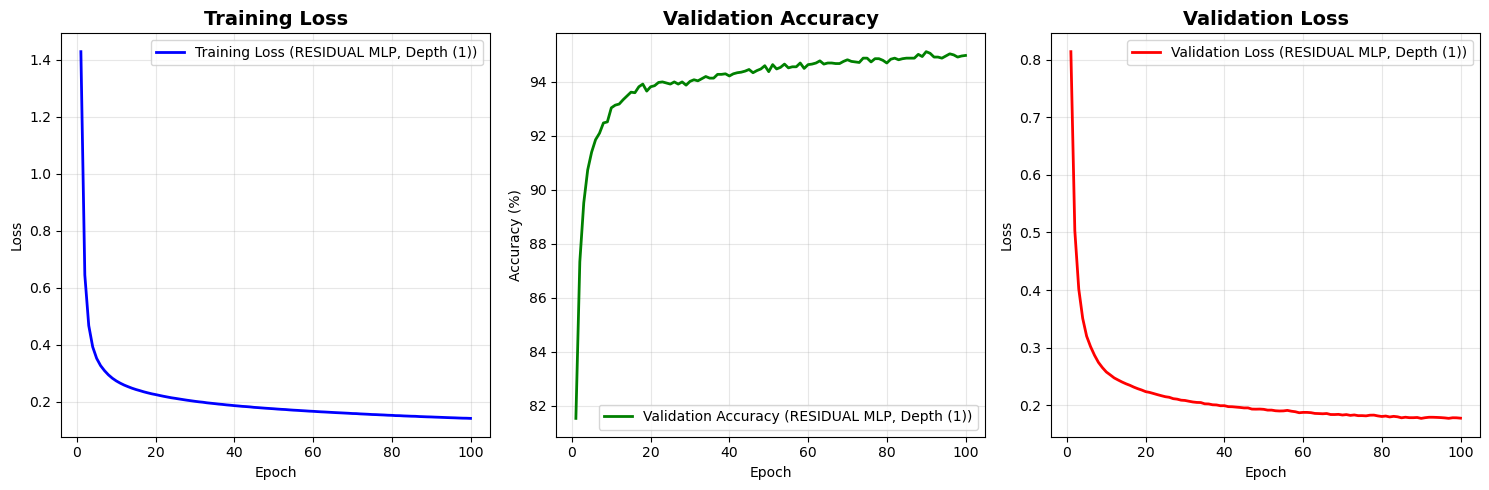

Test Accuracy: 94.98%

Classification Report:
              precision    recall  f1-score   support

           0      0.965     0.982     0.973       980
           1      0.976     0.984     0.980      1135
           2      0.959     0.930     0.944      1032
           3      0.921     0.950     0.935      1010
           4      0.952     0.952     0.952       982
           5      0.947     0.923     0.935       892
           6      0.954     0.960     0.957       958
           7      0.946     0.943     0.944      1028
           8      0.935     0.935     0.935       974
           9      0.939     0.934     0.936      1009

    accuracy                          0.950     10000
   macro avg      0.950     0.949     0.949     10000
weighted avg      0.950     0.950     0.950     10000



epoch,▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇██
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▆▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▃▄▄▅▅▅▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇█▇▇██▇█████████
val_loss,█▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
classification_report,precis...
epoch,100
learning_rate,0.0001
train_loss,0.14129
val_accuracy,94.98
val_loss,0.17748


Epoch 0: Train Loss: 1.3442, Val Acc: 83.70%
Epoch 1: Train Loss: 0.4842, Val Acc: 88.74%
Epoch 2: Train Loss: 0.3615, Val Acc: 90.56%
Epoch 3: Train Loss: 0.3134, Val Acc: 91.84%
Epoch 4: Train Loss: 0.2851, Val Acc: 92.36%
Epoch 5: Train Loss: 0.2657, Val Acc: 92.54%
Epoch 6: Train Loss: 0.2513, Val Acc: 93.02%
Epoch 7: Train Loss: 0.2392, Val Acc: 93.26%
Epoch 8: Train Loss: 0.2291, Val Acc: 93.40%
Epoch 9: Train Loss: 0.2208, Val Acc: 93.62%
Epoch 10: Train Loss: 0.2137, Val Acc: 94.02%
Epoch 11: Train Loss: 0.2070, Val Acc: 94.36%
Epoch 12: Train Loss: 0.2015, Val Acc: 94.36%
Epoch 13: Train Loss: 0.1957, Val Acc: 94.34%
Epoch 14: Train Loss: 0.1911, Val Acc: 94.48%
Epoch 15: Train Loss: 0.1869, Val Acc: 94.34%
Epoch 16: Train Loss: 0.1833, Val Acc: 94.72%
Epoch 17: Train Loss: 0.1793, Val Acc: 94.58%
Epoch 18: Train Loss: 0.1760, Val Acc: 94.84%
Epoch 19: Train Loss: 0.1729, Val Acc: 94.64%
Epoch 20: Train Loss: 0.1704, Val Acc: 94.88%
Epoch 21: Train Loss: 0.1671, Val Acc: 94.78

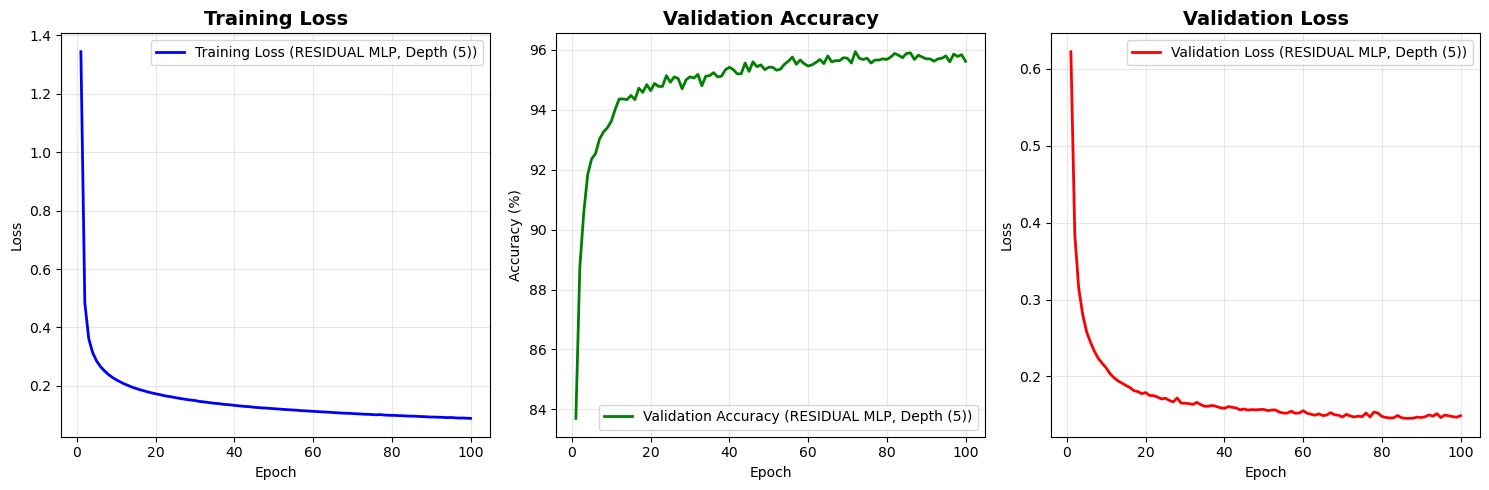

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Test Accuracy: 95.43%

Classification Report:
              precision    recall  f1-score   support

           0      0.954     0.984     0.968       980
           1      0.979     0.980     0.979      1135
           2      0.965     0.948     0.956      1032
           3      0.951     0.951     0.951      1010
           4      0.937     0.969     0.953       982
           5      0.955     0.923     0.938       892
           6      0.950     0.972     0.961       958
           7      0.970     0.946     0.958      1028
           8      0.921     0.943     0.932       974
           9      0.958     0.923     0.940      1009

    accuracy                          0.954     10000
   macro avg      0.954     0.954     0.954     10000
weighted avg      0.955     0.954     0.954     10000



epoch,▁▁▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▂▃▄▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇███▇██▇█▇██
val_loss,█▆▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
classification_report,precis...
epoch,100
learning_rate,0.0001
train_loss,0.08878
val_accuracy,95.62
val_loss,0.14871


Epoch 0: Train Loss: 1.3310, Val Acc: 83.02%
Epoch 1: Train Loss: 0.4926, Val Acc: 88.94%
Epoch 2: Train Loss: 0.3607, Val Acc: 91.06%
Epoch 3: Train Loss: 0.3051, Val Acc: 92.42%
Epoch 4: Train Loss: 0.2724, Val Acc: 92.98%
Epoch 5: Train Loss: 0.2509, Val Acc: 93.44%
Epoch 6: Train Loss: 0.2350, Val Acc: 93.76%
Epoch 7: Train Loss: 0.2218, Val Acc: 93.80%
Epoch 8: Train Loss: 0.2122, Val Acc: 94.16%
Epoch 9: Train Loss: 0.2040, Val Acc: 94.30%
Epoch 10: Train Loss: 0.1967, Val Acc: 94.54%
Epoch 11: Train Loss: 0.1901, Val Acc: 94.54%
Epoch 12: Train Loss: 0.1847, Val Acc: 94.58%
Epoch 13: Train Loss: 0.1795, Val Acc: 95.00%
Epoch 14: Train Loss: 0.1746, Val Acc: 94.92%
Epoch 15: Train Loss: 0.1706, Val Acc: 94.94%
Epoch 16: Train Loss: 0.1670, Val Acc: 95.22%
Epoch 17: Train Loss: 0.1640, Val Acc: 95.40%
Epoch 18: Train Loss: 0.1607, Val Acc: 95.42%
Epoch 19: Train Loss: 0.1572, Val Acc: 95.20%
Epoch 20: Train Loss: 0.1546, Val Acc: 95.52%
Epoch 21: Train Loss: 0.1524, Val Acc: 95.38

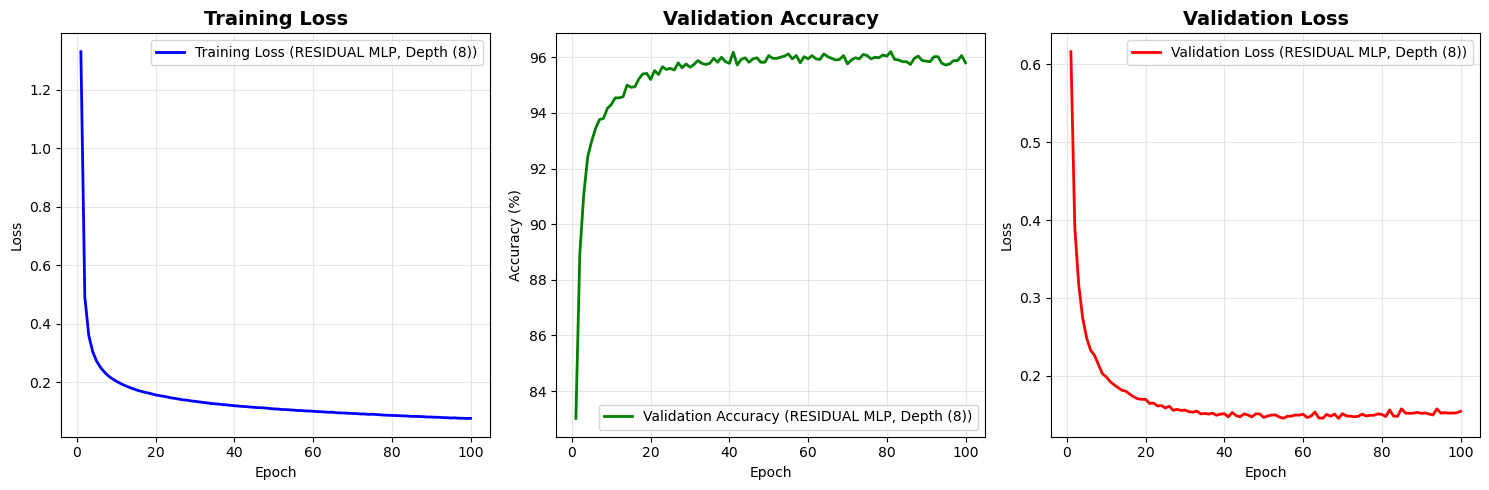

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Test Accuracy: 95.99%

Classification Report:
              precision    recall  f1-score   support

           0      0.977     0.981     0.979       980
           1      0.981     0.983     0.982      1135
           2      0.970     0.957     0.963      1032
           3      0.955     0.956     0.956      1010
           4      0.943     0.956     0.949       982
           5      0.953     0.946     0.949       892
           6      0.961     0.965     0.963       958
           7      0.958     0.966     0.962      1028
           8      0.952     0.939     0.946       974
           9      0.946     0.944     0.945      1009

    accuracy                          0.960     10000
   macro avg      0.960     0.959     0.959     10000
weighted avg      0.960     0.960     0.960     10000



epoch,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇██
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▆▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▆▆▆▇▇▇▇▇▇▇▇██▇█▇█▇███████▇█████████▇█
val_loss,█▅▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
classification_report,precis...
epoch,100
learning_rate,0.0001
train_loss,0.07696
val_accuracy,95.8
val_loss,0.15433


Epoch 0: Train Loss: 2.9814, Val Acc: 25.26%
Epoch 1: Train Loss: 1.5941, Val Acc: 68.94%
Epoch 2: Train Loss: 0.7842, Val Acc: 82.38%
Epoch 3: Train Loss: 0.5406, Val Acc: 87.20%
Epoch 4: Train Loss: 0.4385, Val Acc: 89.60%
Epoch 5: Train Loss: 0.3785, Val Acc: 90.48%
Epoch 6: Train Loss: 0.3378, Val Acc: 91.68%
Epoch 7: Train Loss: 0.3078, Val Acc: 91.98%
Epoch 8: Train Loss: 0.2860, Val Acc: 92.52%
Epoch 9: Train Loss: 0.2699, Val Acc: 92.82%
Epoch 10: Train Loss: 0.2555, Val Acc: 93.32%
Epoch 11: Train Loss: 0.2416, Val Acc: 93.30%
Epoch 12: Train Loss: 0.2262, Val Acc: 93.66%
Epoch 13: Train Loss: 0.2158, Val Acc: 93.86%
Epoch 14: Train Loss: 0.2066, Val Acc: 94.08%
Epoch 15: Train Loss: 0.1980, Val Acc: 94.16%
Epoch 16: Train Loss: 0.1910, Val Acc: 94.28%
Epoch 17: Train Loss: 0.1854, Val Acc: 94.42%
Epoch 18: Train Loss: 0.1803, Val Acc: 94.50%
Epoch 19: Train Loss: 0.1751, Val Acc: 94.70%
Epoch 20: Train Loss: 0.1701, Val Acc: 94.68%
Epoch 21: Train Loss: 0.1668, Val Acc: 94.82

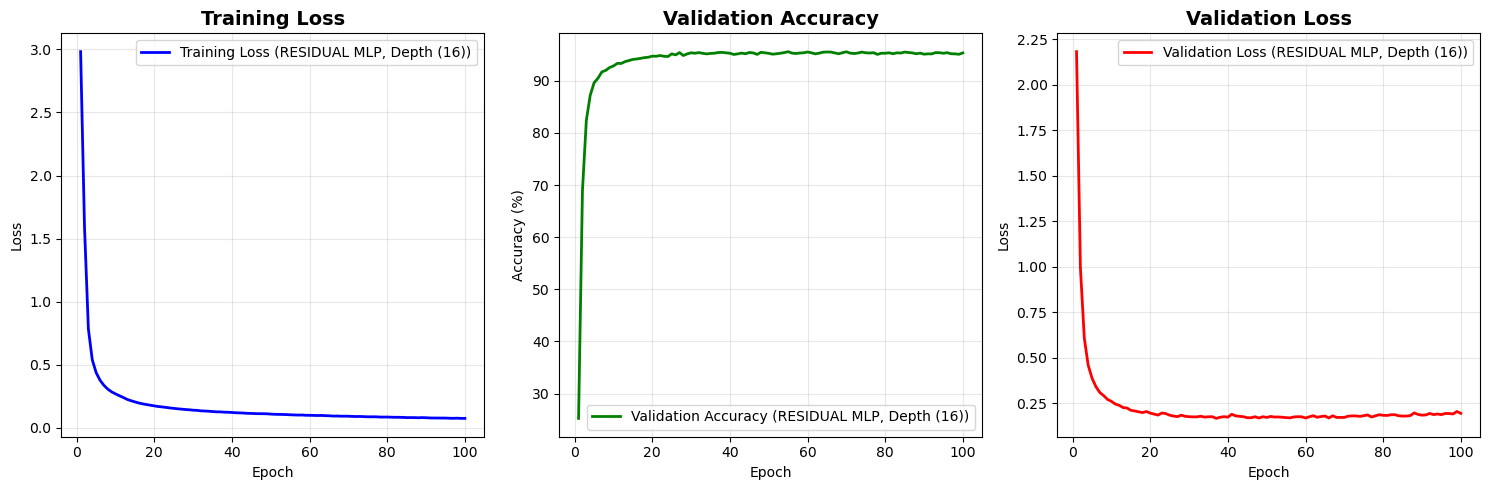

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Test Accuracy: 94.99%

Classification Report:
              precision    recall  f1-score   support

           0      0.964     0.982     0.973       980
           1      0.975     0.981     0.978      1135
           2      0.945     0.953     0.949      1032
           3      0.935     0.950     0.943      1010
           4      0.934     0.966     0.950       982
           5      0.961     0.927     0.944       892
           6      0.955     0.973     0.964       958
           7      0.957     0.939     0.948      1028
           8      0.924     0.918     0.921       974
           9      0.948     0.905     0.926      1009

    accuracy                          0.950     10000
   macro avg      0.950     0.949     0.949     10000
weighted avg      0.950     0.950     0.950     10000



epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▆▇▇███████████████████████████████████
val_loss,█▅▃▃▂▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▂▂▂▂▂
classification_report,precis...
epoch,100
learning_rate,0.0001
train_loss,0.076
val_accuracy,95.32
val_loss,0.19447


In [12]:
for depth in depth_values:
    name_run = "esercizio1.2 - depth: " + str(depth)
    model_residual_MLP = Residual_MLP(input_size, [width]*depth, num_classes).to(device)
    optimizer = torch.optim.Adam(model_residual_MLP.parameters(), lr=lr)
    run = wandb.init(
        project="lab1",
        name=name_run,
        config={
            "model": "Residual-MLP",
            "epochs": 100,
            "learning_rate": 0.0001,
            "batch_size": 128,
            "input_size": 28*28,
            "width": width,
            "depth": depth,
            "num_classes": 10,
            "optimizer": "Adam",
            "loss_function": "CrossEntropyLoss"
        }
    )
    run.watch(model_residual_MLP, log="gradients", log_freq=1)
    train_losses, val_accuracies, val_losses = train(model_residual_MLP, dl_train, dl_val, epochs, criterion, optimizer, device)
    print("RESIDUAL MLP")
    plot_training_metrics(train_losses=train_losses,val_accuracies=val_accuracies, val_losses=val_losses, save_path="/plot", model_name="RESIDUAL MLP", model_depth=depth)
    (accuracy, _, report) = evaluate(model_residual_MLP, dl_test, device, log_wandb=True)

    print(f'Test Accuracy: {accuracy:.2f}%')
    print(f'\nClassification Report:\n{report}')
    wandb.finish()


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇████
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇███▇████████████████
val_loss,█▆▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
classification_report,precis...
epoch,100
learning_rate,0.0001
train_loss,0.13842
val_accuracy,94.68
val_loss,0.17559


Epoch 0: Train Loss: 1.2975, Val Acc: 84.90%
Epoch 1: Train Loss: 0.5673, Val Acc: 89.30%
Epoch 2: Train Loss: 0.4268, Val Acc: 90.70%
Epoch 3: Train Loss: 0.3709, Val Acc: 91.42%
Epoch 4: Train Loss: 0.3403, Val Acc: 91.70%
Epoch 5: Train Loss: 0.3207, Val Acc: 91.92%
Epoch 6: Train Loss: 0.3066, Val Acc: 92.08%
Epoch 7: Train Loss: 0.2960, Val Acc: 92.38%
Epoch 8: Train Loss: 0.2873, Val Acc: 92.58%
Epoch 9: Train Loss: 0.2800, Val Acc: 92.74%
Epoch 10: Train Loss: 0.2735, Val Acc: 92.78%
Epoch 11: Train Loss: 0.2679, Val Acc: 92.92%
Epoch 12: Train Loss: 0.2627, Val Acc: 93.10%
Epoch 13: Train Loss: 0.2582, Val Acc: 93.00%
Epoch 14: Train Loss: 0.2537, Val Acc: 93.20%
Epoch 15: Train Loss: 0.2495, Val Acc: 93.22%
Epoch 16: Train Loss: 0.2454, Val Acc: 93.14%
Epoch 17: Train Loss: 0.2417, Val Acc: 93.26%
Epoch 18: Train Loss: 0.2378, Val Acc: 93.36%
Epoch 19: Train Loss: 0.2343, Val Acc: 93.26%
Epoch 20: Train Loss: 0.2309, Val Acc: 93.40%
Epoch 21: Train Loss: 0.2275, Val Acc: 93.38

FileNotFoundError: [Errno 2] No such file or directory: '/plot/MPL_depth(1).png'

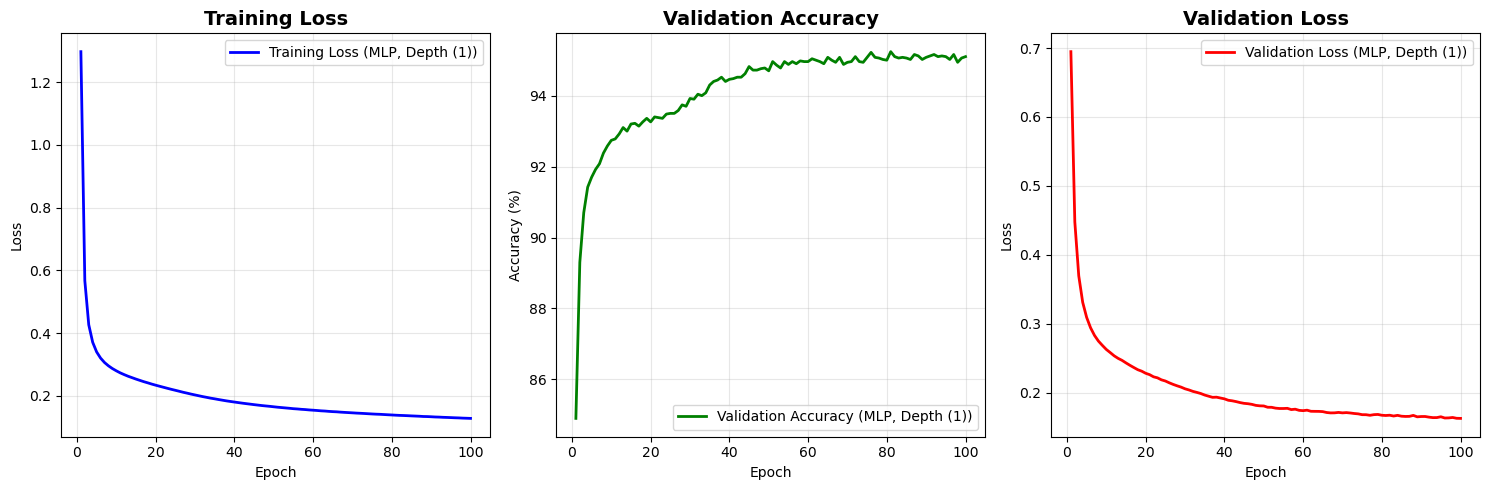

In [ ]:
for depth in depth_values:
    name_run = "esercizio1.2 - depth: " + str(depth)
    model_MLP = My_Configurable_MLP(input_size, [width]*depth, num_classes).to(device)
    optimizer = torch.optim.Adam(model_MLP.parameters(), lr=lr)
    run = wandb.init(
        project="lab1",
        name=name_run,
        config={
            "model": "MLP",
            "epochs": 100,
            "learning_rate": 0.0001,
            "batch_size": 128,
            "input_size": 28*28,
            "width": width,
            "depth": depth,
            "num_classes": 10,
            "optimizer": "Adam",
            "loss_function": "CrossEntropyLoss"
        }
    )   
    run.watch(model_residual_MLP, log="gradients", log_freq=1)
    train_losses, val_accuracies, val_losses = train(model_MLP, dl_train, dl_val, epochs, criterion, optimizer, device)
    print("MLP")
    plot_training_metrics(train_losses=train_losses,val_accuracies=val_accuracies, val_losses=val_losses, save_path=f"plot/MPL_depth({depth})", model_name="MLP", model_depth=depth)
    (accuracy, _, report) = evaluate(model_MLP, dl_test, device, log_wandb=True)

    print(f'Test Accuracy: {accuracy:.2f}%')
    print(f'\nClassification Report:\n{report}')
    wandb.finish()








### Exercise 1.3: Rinse and Repeat (but with a CNN)

Repeat the verification you did above, but with **Convolutional** Neural Networks. If you were careful about abstracting your model and training code, this should be a simple exercise. Show that **deeper** CNNs *without* residual connections do not always work better and **even deeper** ones *with* residual connections.

**Hint**: You probably should do this exercise using CIFAR-10, since MNIST is *very* easy (at least up to about 99% accuracy).

**Tip**: Feel free to reuse the ResNet building blocks defined in `torchvision.models.resnet` (e.g. [BasicBlock](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py#L59) which handles the cascade of 3x3 convolutions, skip connections, and optional downsampling). This is an excellent exercise in code diving. 

**Spoiler**: Depending on the optional exercises you plan to do below, you should think *very* carefully about the architectures of your CNNs here (so you can reuse them!).

In [31]:
class My_Configurable_CNN(nn.Module):
    def __init__(self, input_size, input_channels, hidden_channels, num_classes):
        super(My_Configurable_CNN, self).__init__()
        self.features = nn.ModuleList()
        layer_input_channels = input_channels
        h, w = input_size

        # Convolutional layers
        for layer_size in hidden_channels[:-1]:  # tutti i layer tranne l'ultimo
            self.features.append(nn.Conv2d(layer_input_channels, layer_size, kernel_size=3, padding=1))
            self.features.append(nn.ReLU())
            self.features.append(nn.MaxPool2d(kernel_size=2, stride=2))
            layer_input_channels = layer_size
            h //= 2
            w //= 2
            
        # Ultimo layer convoluzionale (senza pooling)
        self.final_conv = nn.Conv2d(layer_input_channels, hidden_channels[-1], kernel_size=3, padding=1)
        self.gap = nn.AdaptiveAvgPool2d(1)  # Global Average Pooling
        self.classifier = nn.Linear(hidden_channels[-1], num_classes)

    def forward(self, x, return_cam=False):
        # Forward attraverso i layer feature
        for layer in self.features:
            x = layer(x)
            
        # Ultimo layer convoluzionale
        features = self.final_conv(x)  # Salva le feature maps
        
        # GAP e classificazione
        x = self.gap(features)
        x = x.view(x.size(0), -1)
        logits = self.classifier(x)
        
        if return_cam:
            return logits, features
        return logits

    def get_cam(self, features, class_idx):
        # Ottieni i pesi del classificatore per la classe specificata
        weights = self.classifier.weight[class_idx].view(-1, 1, 1)  # Reshape per il broadcasting
    
        # Calcola CAM (moltiplicazione elemento per elemento e somma sui canali)
        # features: (batch_size, channels, h, w)
        # weights: (channels, 1, 1)
        cam = (weights * features).sum(dim=1)  # Somma sui canali
    
        return cam

In [25]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        # Proiezione se cambia il numero di canali
        self.proj = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        residual = self.proj(x)
        out = self.conv(x)
        out = self.relu(out)
        out = self.pool(out)
        residual = self.pool(residual)
        return out + residual

class My_Residual_CNN(nn.Module):
    def __init__(self, input_size, input_channels, hidden_channels, num_classes):
        super().__init__()
        self.features = nn.ModuleList()
        h, w = input_size
        in_channels = input_channels

        # Feature extraction layers
        for out_channels in hidden_channels[:-1]:
            self.features.append(ResidualBlock(in_channels, out_channels))
            in_channels = out_channels
            h //= 2
            w //= 2

        # Final conv layer for CAM
        self.final_conv = ResidualBlock(in_channels, hidden_channels[-1])
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Linear(hidden_channels[-1], num_classes)

    def forward(self, x, return_cam=False):
        # Feature extraction
        for layer in self.features:
            x = layer(x)
            
        # Final conv layer
        features = self.final_conv(x)
        
        # Classification
        x = self.gap(features)
        x = x.flatten(1)
        logits = self.classifier(x)
        
        if return_cam:
            return logits, features
        return logits

    def get_cam(self, features, class_idx):
        weights = self.classifier.weight[class_idx]
        batch_size, channels, h, w = features.shape
        cam = torch.zeros((batch_size, h, w), device=features.device)
        
        for i in range(channels):
            cam += weights[i] * features[:, i, :, :]
            
        return cam

In [26]:
transform_cifar10 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

ds_train = CIFAR10(root='./data', train=True, download=True, transform=transform_cifar10)
ds_test = CIFAR10(root='./data', train=False, download=True, transform=transform_cifar10)

val_size = 5000
I = np.random.permutation(len(ds_train))
ds_val = Subset(ds_train, I[:val_size])
ds_train = Subset(ds_train, I[val_size:])



Files already downloaded and verified
Files already downloaded and verified


In [27]:

device = 'cuda' if torch.cuda.is_available else 'cpu'
batch_size = 128
epochs = 50
input_size = (32, 32)  # CIFAR-10 images are 32x32
input_channels = 3  # CIFAR-10 images have 3 channels (RGB)
num_classes = 10
# Dataloaders.
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=True, num_workers=4)
dl_val   = torch.utils.data.DataLoader(ds_val, batch_size, num_workers=4)
dl_test  = torch.utils.data.DataLoader(ds_test, batch_size, shuffle=True, num_workers=4)

criterion = nn.CrossEntropyLoss()


Epoch 0: Train Loss: 2.2116, Val Acc: 20.54%
Epoch 1: Train Loss: 2.0972, Val Acc: 22.28%
Epoch 2: Train Loss: 2.0550, Val Acc: 24.12%
Epoch 3: Train Loss: 2.0238, Val Acc: 26.46%
Epoch 4: Train Loss: 1.9893, Val Acc: 27.38%
Epoch 5: Train Loss: 1.9513, Val Acc: 30.02%
Epoch 6: Train Loss: 1.9128, Val Acc: 30.30%
Epoch 7: Train Loss: 1.8733, Val Acc: 31.32%
Epoch 8: Train Loss: 1.8376, Val Acc: 32.64%
Epoch 9: Train Loss: 1.8073, Val Acc: 33.04%
Epoch 10: Train Loss: 1.7856, Val Acc: 33.30%
Epoch 11: Train Loss: 1.7696, Val Acc: 33.48%
Epoch 12: Train Loss: 1.7580, Val Acc: 34.02%
Epoch 13: Train Loss: 1.7491, Val Acc: 34.50%
Epoch 14: Train Loss: 1.7422, Val Acc: 34.54%
Epoch 15: Train Loss: 1.7365, Val Acc: 34.34%
Epoch 16: Train Loss: 1.7321, Val Acc: 34.82%
Epoch 17: Train Loss: 1.7275, Val Acc: 33.84%
Epoch 18: Train Loss: 1.7237, Val Acc: 34.44%
Epoch 19: Train Loss: 1.7204, Val Acc: 35.16%
Epoch 20: Train Loss: 1.7172, Val Acc: 35.60%
Epoch 21: Train Loss: 1.7143, Val Acc: 34.66

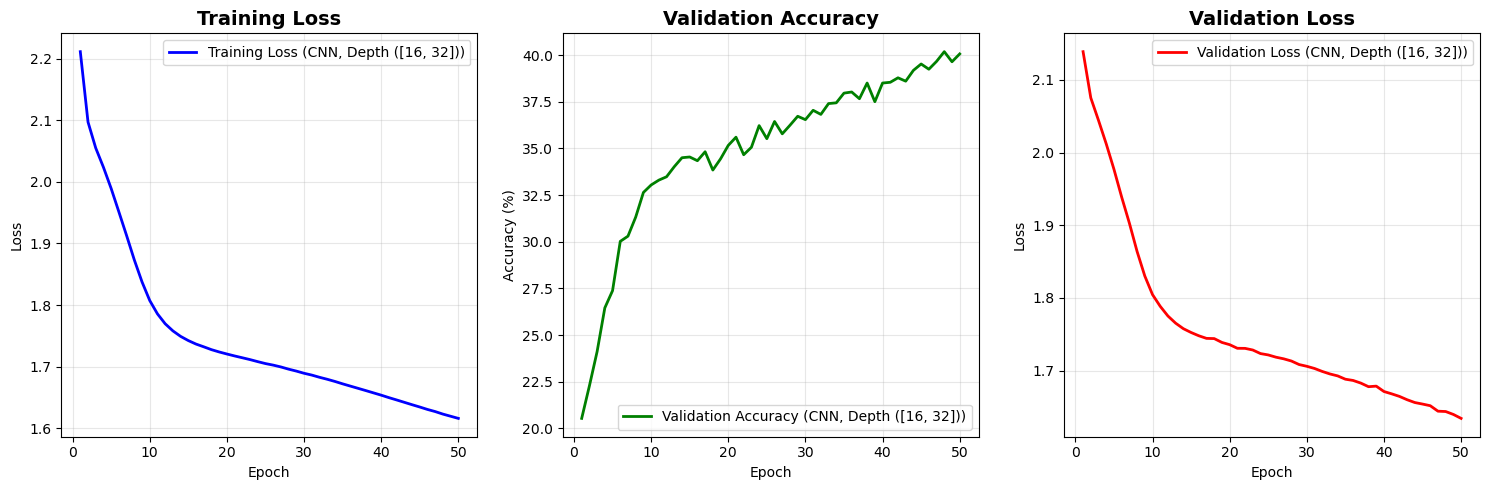

Test Accuracy: 41.25%

Classification Report:
              precision    recall  f1-score   support

           0      0.443     0.416     0.429      1000
           1      0.469     0.494     0.481      1000
           2      0.303     0.211     0.249      1000
           3      0.282     0.188     0.226      1000
           4      0.316     0.274     0.294      1000
           5      0.409     0.379     0.393      1000
           6      0.409     0.641     0.500      1000
           7      0.428     0.414     0.421      1000
           8      0.493     0.626     0.552      1000
           9      0.461     0.482     0.471      1000

    accuracy                          0.412     10000
   macro avg      0.401     0.412     0.401     10000
weighted avg      0.401     0.412     0.401     10000



wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▆▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▂▃▃▅▅▅▆▆▆▆▆▆▆▆▆▆▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇█████
val_loss,█▇▆▆▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
classification_report,precis...
epoch,50
learning_rate,0.0001
train_loss,1.6158
val_accuracy,40.06
val_loss,1.63422


Epoch 0: Train Loss: 2.1261, Val Acc: 26.48%
Epoch 1: Train Loss: 1.9595, Val Acc: 28.42%
Epoch 2: Train Loss: 1.8762, Val Acc: 31.12%
Epoch 3: Train Loss: 1.8205, Val Acc: 32.96%
Epoch 4: Train Loss: 1.7804, Val Acc: 34.12%
Epoch 5: Train Loss: 1.7433, Val Acc: 35.54%
Epoch 6: Train Loss: 1.7094, Val Acc: 35.46%
Epoch 7: Train Loss: 1.6827, Val Acc: 36.88%
Epoch 8: Train Loss: 1.6601, Val Acc: 38.28%
Epoch 9: Train Loss: 1.6422, Val Acc: 38.62%
Epoch 10: Train Loss: 1.6273, Val Acc: 39.02%
Epoch 11: Train Loss: 1.6125, Val Acc: 40.48%
Epoch 12: Train Loss: 1.5994, Val Acc: 40.04%
Epoch 13: Train Loss: 1.5890, Val Acc: 40.70%
Epoch 14: Train Loss: 1.5766, Val Acc: 41.64%
Epoch 15: Train Loss: 1.5667, Val Acc: 41.88%
Epoch 16: Train Loss: 1.5575, Val Acc: 42.16%
Epoch 17: Train Loss: 1.5463, Val Acc: 42.42%
Epoch 18: Train Loss: 1.5371, Val Acc: 43.46%
Epoch 19: Train Loss: 1.5288, Val Acc: 43.48%
Epoch 20: Train Loss: 1.5184, Val Acc: 44.44%
Epoch 21: Train Loss: 1.5118, Val Acc: 44.10

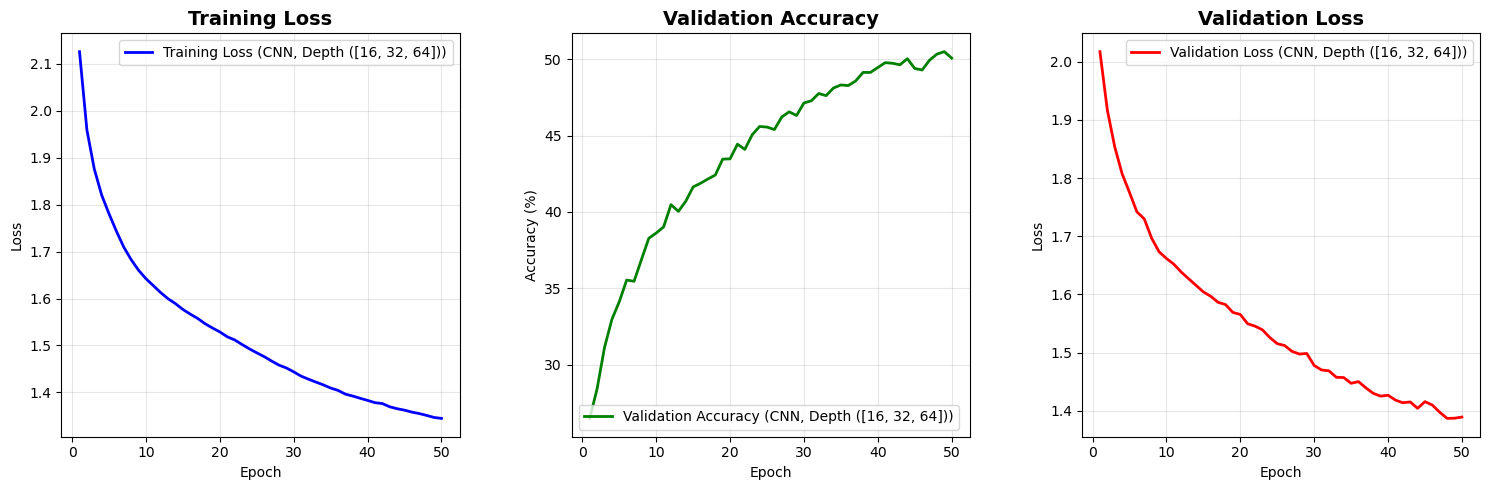

Test Accuracy: 51.00%

Classification Report:
              precision    recall  f1-score   support

           0      0.520     0.473     0.495      1000
           1      0.597     0.633     0.614      1000
           2      0.423     0.331     0.371      1000
           3      0.332     0.342     0.337      1000
           4      0.443     0.422     0.432      1000
           5      0.447     0.502     0.473      1000
           6      0.592     0.683     0.634      1000
           7      0.623     0.509     0.560      1000
           8      0.528     0.713     0.607      1000
           9      0.599     0.492     0.540      1000

    accuracy                          0.510     10000
   macro avg      0.510     0.510     0.507     10000
weighted avg      0.510     0.510     0.507     10000



wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▆▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▂▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇██████████
val_loss,█▆▆▅▅▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
classification_report,precis...
epoch,50
learning_rate,0.0001
train_loss,1.34449
val_accuracy,50.08
val_loss,1.38939


Epoch 0: Train Loss: 2.0669, Val Acc: 30.48%
Epoch 1: Train Loss: 1.8362, Val Acc: 32.82%
Epoch 2: Train Loss: 1.7385, Val Acc: 35.92%
Epoch 3: Train Loss: 1.6834, Val Acc: 38.24%
Epoch 4: Train Loss: 1.6390, Val Acc: 39.20%
Epoch 5: Train Loss: 1.6006, Val Acc: 40.72%
Epoch 6: Train Loss: 1.5663, Val Acc: 42.82%
Epoch 7: Train Loss: 1.5391, Val Acc: 43.26%
Epoch 8: Train Loss: 1.5168, Val Acc: 44.58%
Epoch 9: Train Loss: 1.4983, Val Acc: 44.62%
Epoch 10: Train Loss: 1.4774, Val Acc: 45.60%
Epoch 11: Train Loss: 1.4574, Val Acc: 45.36%
Epoch 12: Train Loss: 1.4411, Val Acc: 47.08%
Epoch 13: Train Loss: 1.4240, Val Acc: 47.16%
Epoch 14: Train Loss: 1.4088, Val Acc: 46.90%
Epoch 15: Train Loss: 1.3902, Val Acc: 48.86%
Epoch 16: Train Loss: 1.3757, Val Acc: 48.68%
Epoch 17: Train Loss: 1.3633, Val Acc: 49.54%
Epoch 18: Train Loss: 1.3524, Val Acc: 49.76%
Epoch 19: Train Loss: 1.3364, Val Acc: 49.54%
Epoch 20: Train Loss: 1.3301, Val Acc: 50.64%
Epoch 21: Train Loss: 1.3165, Val Acc: 51.64

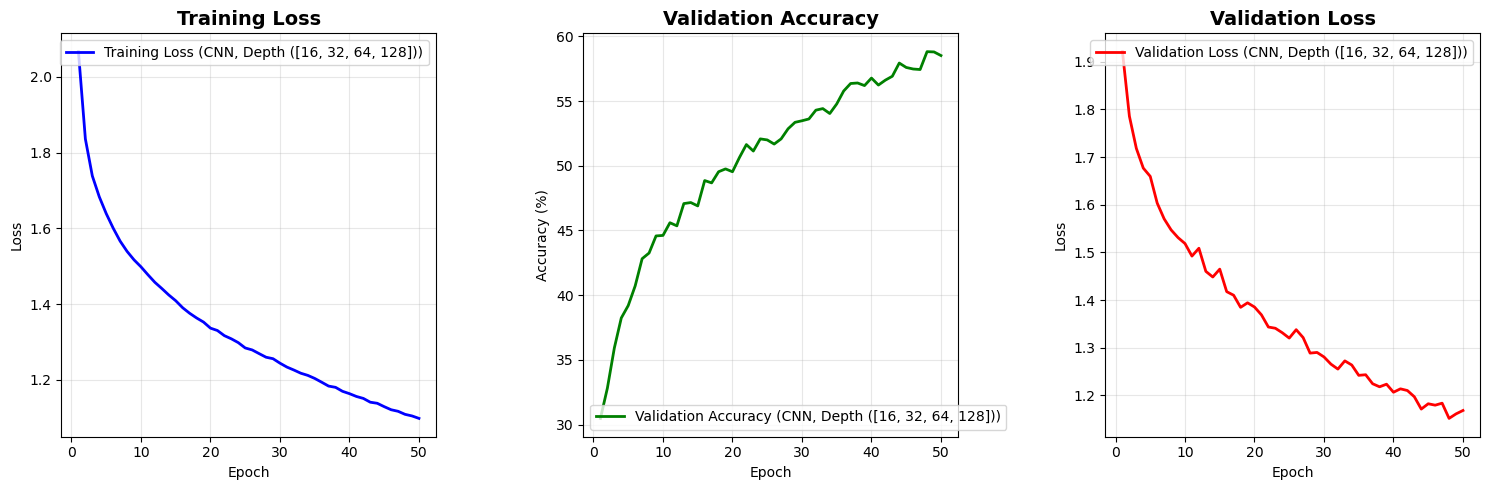

Test Accuracy: 59.69%

Classification Report:
              precision    recall  f1-score   support

           0      0.538     0.700     0.609      1000
           1      0.760     0.660     0.707      1000
           2      0.489     0.499     0.494      1000
           3      0.462     0.334     0.388      1000
           4      0.500     0.567     0.532      1000
           5      0.503     0.576     0.537      1000
           6      0.738     0.634     0.682      1000
           7      0.629     0.657     0.643      1000
           8      0.668     0.767     0.714      1000
           9      0.758     0.575     0.654      1000

    accuracy                          0.597     10000
   macro avg      0.605     0.597     0.596     10000
weighted avg      0.605     0.597     0.596     10000



wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▇▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▂▂▃▃▄▄▄▄▅▅▅▅▆▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████
val_loss,█▇▇▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁
classification_report,precis...
epoch,50
learning_rate,0.0001
train_loss,1.09789
val_accuracy,58.52
val_loss,1.16847


Epoch 0: Train Loss: 1.9125, Val Acc: 36.32%
Epoch 1: Train Loss: 1.6276, Val Acc: 41.82%
Epoch 2: Train Loss: 1.5162, Val Acc: 45.64%
Epoch 3: Train Loss: 1.4494, Val Acc: 46.60%
Epoch 4: Train Loss: 1.3955, Val Acc: 48.86%
Epoch 5: Train Loss: 1.3508, Val Acc: 48.84%
Epoch 6: Train Loss: 1.3171, Val Acc: 49.86%
Epoch 7: Train Loss: 1.2856, Val Acc: 52.38%
Epoch 8: Train Loss: 1.2595, Val Acc: 53.22%
Epoch 9: Train Loss: 1.2290, Val Acc: 54.04%
Epoch 10: Train Loss: 1.2028, Val Acc: 55.48%
Epoch 11: Train Loss: 1.1791, Val Acc: 55.48%
Epoch 12: Train Loss: 1.1536, Val Acc: 57.68%
Epoch 13: Train Loss: 1.1280, Val Acc: 58.22%
Epoch 14: Train Loss: 1.1133, Val Acc: 58.22%
Epoch 15: Train Loss: 1.0879, Val Acc: 59.36%
Epoch 16: Train Loss: 1.0711, Val Acc: 58.96%
Epoch 17: Train Loss: 1.0489, Val Acc: 59.14%
Epoch 18: Train Loss: 1.0370, Val Acc: 60.40%
Epoch 19: Train Loss: 1.0188, Val Acc: 61.10%
Epoch 20: Train Loss: 1.0054, Val Acc: 61.54%
Epoch 21: Train Loss: 0.9858, Val Acc: 61.12

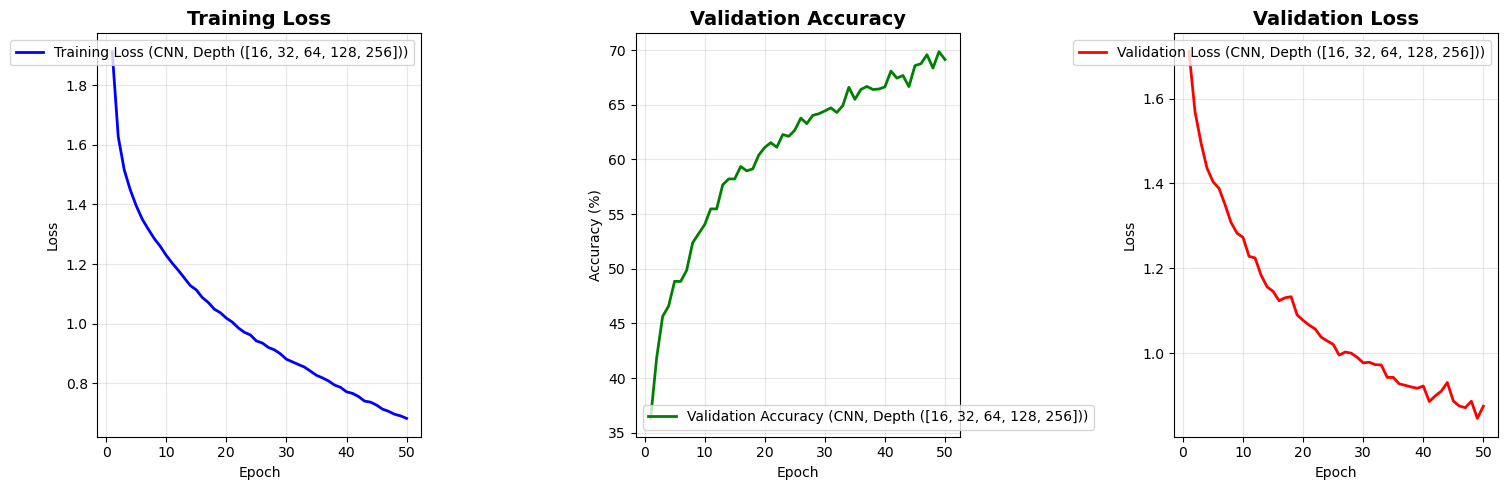

Test Accuracy: 69.85%

Classification Report:
              precision    recall  f1-score   support

           0      0.659     0.821     0.731      1000
           1      0.752     0.858     0.801      1000
           2      0.560     0.640     0.598      1000
           3      0.538     0.506     0.522      1000
           4      0.762     0.521     0.619      1000
           5      0.734     0.471     0.574      1000
           6      0.708     0.837     0.767      1000
           7      0.680     0.836     0.750      1000
           8      0.860     0.761     0.807      1000
           9      0.808     0.734     0.769      1000

    accuracy                          0.699     10000
   macro avg      0.706     0.699     0.694     10000
weighted avg      0.706     0.699     0.694     10000



wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_accuracy,▁▂▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████
val_loss,█▇▆▆▅▅▅▅▅▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
classification_report,precis...
epoch,50
learning_rate,0.0001
train_loss,0.68252
val_accuracy,69.14
val_loss,0.87547


In [28]:
from sklearn.metrics import accuracy_score, classification_report
depth_configs = {
    'shallow': [16, 32],
    'medium': [16, 32, 64],
    'deep': [16, 32, 64, 128],
    'very_deep': [16, 32, 64, 128, 256]
}

for depth_name, hidden_channels in depth_configs.items():
    model_CNN = My_Configurable_CNN(input_size, input_channels, hidden_channels, num_classes).to(device)
    lr = 0.0001
    optimizer = torch.optim.Adam(model_CNN.parameters(), lr=lr)
    name_run = f"esercizio1.3 - {depth_name} CNN "
    wandb.init(
        project="lab1",
        name=name_run,
        config={
            "model": "CNN",
            "epochs": 50,
            "learning_rate": 0.0001,
            "batch_size": 128,
            "input_size": 28*28,
            "input_channels": input_channels,
            "hidden_channels": hidden_channels,
            "num_classes": 10,
            "optimizer": "Adam",
            "loss_function": "CrossEntropyLoss"
        }
    )
    train_losses, val_accuracies, val_losses = train(model_CNN, dl_train, dl_val, epochs, criterion, optimizer, device)
    print("CNN")
    plot_training_metrics(train_losses=train_losses,val_accuracies=val_accuracies, val_losses=val_losses, save_path=f"plot/CNN({depth_name})", model_name="CNN", model_depth=hidden_channels)
    (accuracy, _, report) = evaluate(model_CNN, dl_test, device, log_wandb=True)

    print(f'Test Accuracy: {accuracy:.2f}%')
    print(f'\nClassification Report:\n{report}')

    model_path = f"model_CNN_{depth_name}.pth"
    torch.save({
        'model_state_dict': model_CNN.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'accuracy': accuracy,
        'hidden_channels': hidden_channels,
    }, model_path)

    artifact = wandb.Artifact(
        name=f"model_CNN_{depth_name}", 
        type="model",
        description=f"CNN model with {hidden_channels} depth"
    )
    artifact.add_file(model_path)
    wandb.log_artifact(artifact)
    wandb.finish()








Epoch 0: Train Loss: 2.2241, Val Acc: 22.20%
Epoch 1: Train Loss: 2.0887, Val Acc: 24.98%
Epoch 2: Train Loss: 2.0197, Val Acc: 26.66%
Epoch 3: Train Loss: 1.9740, Val Acc: 29.70%
Epoch 4: Train Loss: 1.9318, Val Acc: 31.36%
Epoch 5: Train Loss: 1.8930, Val Acc: 31.06%
Epoch 6: Train Loss: 1.8595, Val Acc: 32.72%
Epoch 7: Train Loss: 1.8299, Val Acc: 33.24%
Epoch 8: Train Loss: 1.8039, Val Acc: 34.78%
Epoch 9: Train Loss: 1.7811, Val Acc: 35.66%
Epoch 10: Train Loss: 1.7604, Val Acc: 36.02%
Epoch 11: Train Loss: 1.7418, Val Acc: 36.00%
Epoch 12: Train Loss: 1.7254, Val Acc: 37.30%
Epoch 13: Train Loss: 1.7111, Val Acc: 37.74%
Epoch 14: Train Loss: 1.6985, Val Acc: 37.58%
Epoch 15: Train Loss: 1.6872, Val Acc: 38.32%
Epoch 16: Train Loss: 1.6769, Val Acc: 39.08%
Epoch 17: Train Loss: 1.6681, Val Acc: 39.86%
Epoch 18: Train Loss: 1.6598, Val Acc: 39.48%
Epoch 19: Train Loss: 1.6526, Val Acc: 39.68%
Epoch 20: Train Loss: 1.6451, Val Acc: 40.18%
Epoch 21: Train Loss: 1.6385, Val Acc: 40.14

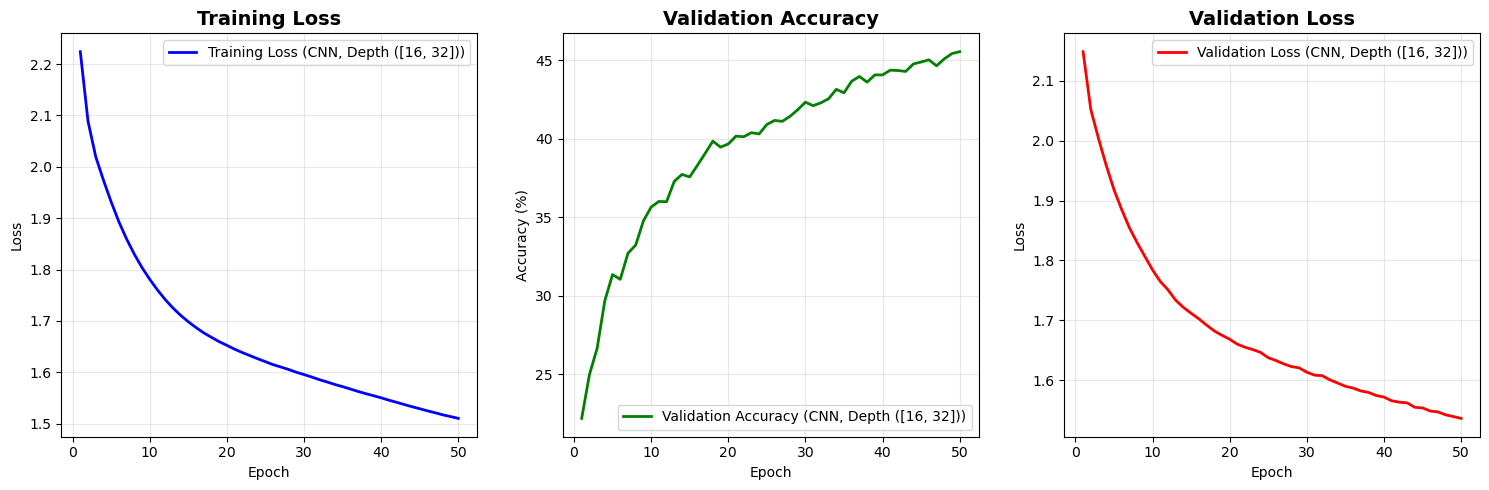

Test Accuracy: 46.48%

Classification Report:
              precision    recall  f1-score   support

           0      0.488     0.471     0.479      1000
           1      0.525     0.578     0.550      1000
           2      0.405     0.302     0.346      1000
           3      0.305     0.271     0.287      1000
           4      0.417     0.434     0.425      1000
           5      0.416     0.448     0.432      1000
           6      0.504     0.566     0.533      1000
           7      0.538     0.428     0.477      1000
           8      0.515     0.641     0.571      1000
           9      0.498     0.509     0.503      1000

    accuracy                          0.465     10000
   macro avg      0.461     0.465     0.460     10000
weighted avg      0.461     0.465     0.460     10000



wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▆▆▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▂▃▄▄▄▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████████
val_loss,██▆▆▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
classification_report,precis...
epoch,50
learning_rate,0.0001
train_loss,1.51042
val_accuracy,45.56
val_loss,1.53638


Epoch 0: Train Loss: 2.0841, Val Acc: 30.14%
Epoch 1: Train Loss: 1.8419, Val Acc: 35.50%
Epoch 2: Train Loss: 1.7288, Val Acc: 37.10%
Epoch 3: Train Loss: 1.6619, Val Acc: 39.50%
Epoch 4: Train Loss: 1.6171, Val Acc: 41.38%
Epoch 5: Train Loss: 1.5856, Val Acc: 41.52%
Epoch 6: Train Loss: 1.5600, Val Acc: 42.74%
Epoch 7: Train Loss: 1.5377, Val Acc: 44.12%
Epoch 8: Train Loss: 1.5180, Val Acc: 44.96%
Epoch 9: Train Loss: 1.4993, Val Acc: 44.88%
Epoch 10: Train Loss: 1.4827, Val Acc: 45.82%
Epoch 11: Train Loss: 1.4696, Val Acc: 46.52%
Epoch 12: Train Loss: 1.4533, Val Acc: 47.38%
Epoch 13: Train Loss: 1.4422, Val Acc: 47.86%
Epoch 14: Train Loss: 1.4285, Val Acc: 47.88%
Epoch 15: Train Loss: 1.4161, Val Acc: 48.20%
Epoch 16: Train Loss: 1.4070, Val Acc: 49.08%
Epoch 17: Train Loss: 1.3976, Val Acc: 48.86%
Epoch 18: Train Loss: 1.3892, Val Acc: 49.50%
Epoch 19: Train Loss: 1.3799, Val Acc: 49.52%
Epoch 20: Train Loss: 1.3717, Val Acc: 50.02%
Epoch 21: Train Loss: 1.3622, Val Acc: 49.14

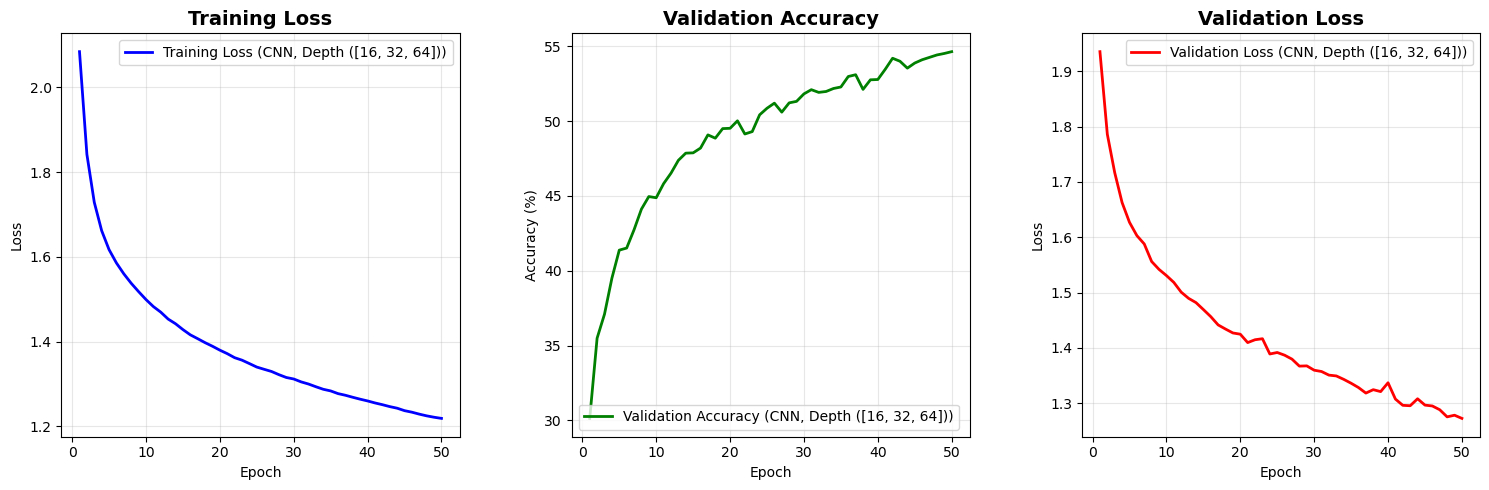

Test Accuracy: 55.28%

Classification Report:
              precision    recall  f1-score   support

           0      0.609     0.613     0.611      1000
           1      0.684     0.560     0.616      1000
           2      0.491     0.363     0.417      1000
           3      0.367     0.400     0.383      1000
           4      0.467     0.564     0.511      1000
           5      0.526     0.401     0.455      1000
           6      0.660     0.623     0.641      1000
           7      0.606     0.593     0.599      1000
           8      0.695     0.658     0.676      1000
           9      0.501     0.753     0.602      1000

    accuracy                          0.553     10000
   macro avg      0.560     0.553     0.551     10000
weighted avg      0.560     0.553     0.551     10000



wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▆▅▅▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▃▄▄▅▅▅▅▅▆▆▆▆▆▇▇▆▆▇▇▇▇▇▇▇▇▇██▇▇████████
val_loss,█▆▆▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▁▁▁▁
classification_report,precis...
epoch,50
learning_rate,0.0001
train_loss,1.21895
val_accuracy,54.64
val_loss,1.27255


Epoch 0: Train Loss: 1.8826, Val Acc: 38.14%
Epoch 1: Train Loss: 1.5777, Val Acc: 44.92%
Epoch 2: Train Loss: 1.4594, Val Acc: 47.20%
Epoch 3: Train Loss: 1.3931, Val Acc: 48.86%
Epoch 4: Train Loss: 1.3483, Val Acc: 49.46%
Epoch 5: Train Loss: 1.3059, Val Acc: 52.44%
Epoch 6: Train Loss: 1.2747, Val Acc: 54.36%
Epoch 7: Train Loss: 1.2456, Val Acc: 53.18%
Epoch 8: Train Loss: 1.2176, Val Acc: 55.24%
Epoch 9: Train Loss: 1.1936, Val Acc: 56.46%
Epoch 10: Train Loss: 1.1702, Val Acc: 57.14%
Epoch 11: Train Loss: 1.1484, Val Acc: 57.30%
Epoch 12: Train Loss: 1.1327, Val Acc: 57.80%
Epoch 13: Train Loss: 1.1151, Val Acc: 59.02%
Epoch 14: Train Loss: 1.0950, Val Acc: 58.22%
Epoch 15: Train Loss: 1.0783, Val Acc: 59.58%
Epoch 16: Train Loss: 1.0659, Val Acc: 60.74%
Epoch 17: Train Loss: 1.0534, Val Acc: 60.78%
Epoch 18: Train Loss: 1.0370, Val Acc: 60.04%
Epoch 19: Train Loss: 1.0289, Val Acc: 61.10%
Epoch 20: Train Loss: 1.0135, Val Acc: 61.38%
Epoch 21: Train Loss: 1.0039, Val Acc: 61.82

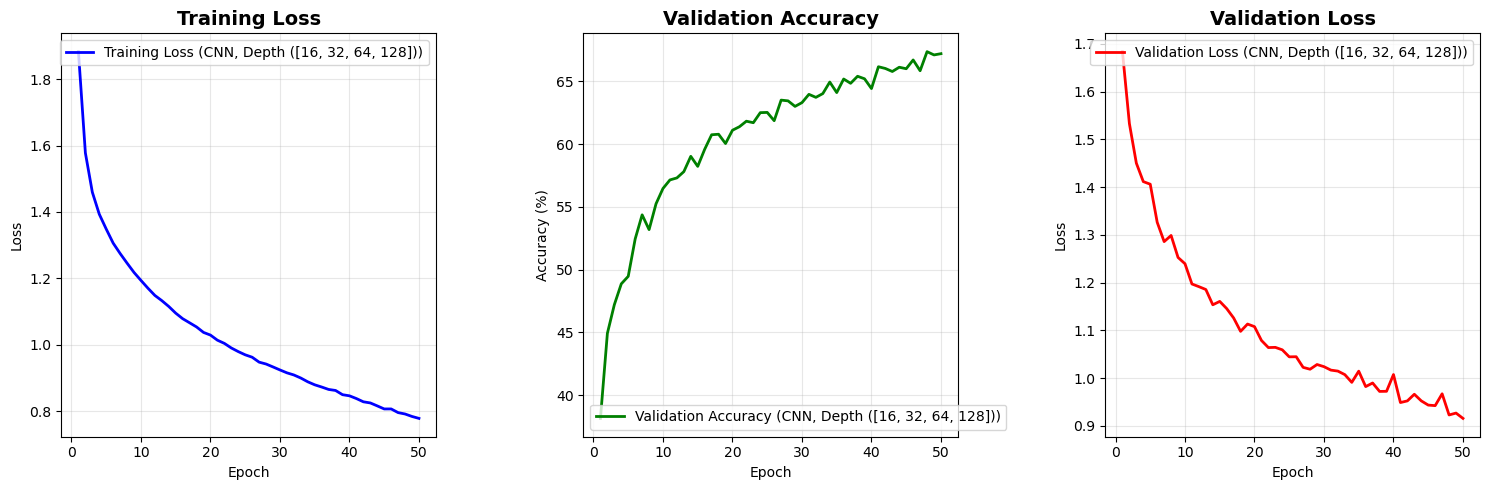

Test Accuracy: 68.15%

Classification Report:
              precision    recall  f1-score   support

           0      0.734     0.719     0.727      1000
           1      0.794     0.782     0.788      1000
           2      0.597     0.568     0.582      1000
           3      0.502     0.474     0.487      1000
           4      0.700     0.569     0.628      1000
           5      0.578     0.569     0.573      1000
           6      0.700     0.808     0.750      1000
           7      0.752     0.689     0.719      1000
           8      0.739     0.853     0.792      1000
           9      0.701     0.784     0.740      1000

    accuracy                          0.681     10000
   macro avg      0.680     0.681     0.679     10000
weighted avg      0.680     0.681     0.679     10000



wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▆▅▅▅▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▃▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇████████
val_loss,█▇▇▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
classification_report,precis...
epoch,50
learning_rate,0.0001
train_loss,0.77803
val_accuracy,67.2
val_loss,0.91574


Epoch 0: Train Loss: 1.7687, Val Acc: 43.80%
Epoch 1: Train Loss: 1.4396, Val Acc: 49.86%
Epoch 2: Train Loss: 1.3153, Val Acc: 53.04%
Epoch 3: Train Loss: 1.2351, Val Acc: 55.30%
Epoch 4: Train Loss: 1.1737, Val Acc: 56.04%
Epoch 5: Train Loss: 1.1249, Val Acc: 58.24%
Epoch 6: Train Loss: 1.0796, Val Acc: 58.82%
Epoch 7: Train Loss: 1.0396, Val Acc: 58.90%
Epoch 8: Train Loss: 1.0045, Val Acc: 60.68%
Epoch 9: Train Loss: 0.9721, Val Acc: 61.34%
Epoch 10: Train Loss: 0.9433, Val Acc: 62.78%
Epoch 11: Train Loss: 0.9112, Val Acc: 63.28%
Epoch 12: Train Loss: 0.8846, Val Acc: 63.82%
Epoch 13: Train Loss: 0.8577, Val Acc: 65.04%
Epoch 14: Train Loss: 0.8329, Val Acc: 65.30%
Epoch 15: Train Loss: 0.8088, Val Acc: 66.36%
Epoch 16: Train Loss: 0.7792, Val Acc: 66.52%
Epoch 17: Train Loss: 0.7576, Val Acc: 66.86%
Epoch 18: Train Loss: 0.7354, Val Acc: 67.02%
Epoch 19: Train Loss: 0.7171, Val Acc: 67.44%
Epoch 20: Train Loss: 0.6901, Val Acc: 68.04%
Epoch 21: Train Loss: 0.6680, Val Acc: 67.40

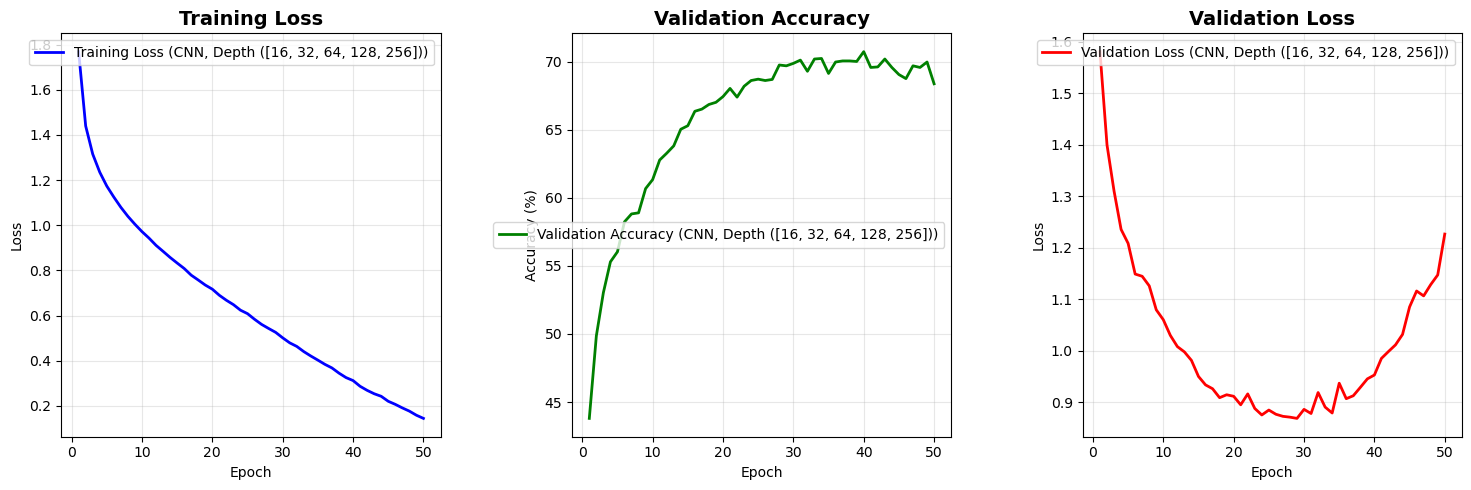

Test Accuracy: 68.91%

Classification Report:
              precision    recall  f1-score   support

           0      0.831     0.661     0.736      1000
           1      0.804     0.773     0.788      1000
           2      0.636     0.576     0.604      1000
           3      0.510     0.501     0.505      1000
           4      0.624     0.678     0.650      1000
           5      0.561     0.613     0.586      1000
           6      0.837     0.684     0.753      1000
           7      0.768     0.723     0.745      1000
           8      0.752     0.854     0.800      1000
           9      0.646     0.828     0.726      1000

    accuracy                          0.689     10000
   macro avg      0.697     0.689     0.689     10000
weighted avg      0.697     0.689     0.689     10000



wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▆▆▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▃▃▄▄▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█████████████▇██▇
val_loss,█▅▅▅▄▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▃▃▃▅
classification_report,precis...
epoch,50
learning_rate,0.0001
train_loss,0.14513
val_accuracy,68.38
val_loss,1.22659


In [29]:
from sklearn.metrics import accuracy_score, classification_report
depth_configs = {
    'shallow': [16, 32],
    'medium': [16, 32, 64],
    'deep': [16, 32, 64, 128],
    'very_deep': [16, 32, 64, 128, 256]
}

for depth_name, hidden_channels in depth_configs.items():
    model_Residual_CNN = My_Residual_CNN(input_size, input_channels, hidden_channels, num_classes).to(device)
    lr = 0.0001
    optimizer = torch.optim.Adam(model_Residual_CNN.parameters(), lr=lr)
    name_run = f"esercizio1.3 - {depth_name} Residual CNN "
    wandb.init(
        project="lab1",
        name=name_run,
        config={
            "model": "Residual CNN",
            "epochs": 50,
            "learning_rate": 0.0001,
            "batch_size": 128,
            "input_size": 28*28,
            "input_channels": input_channels,
            "hidden_channels": hidden_channels,
            "num_classes": 10,
            "optimizer": "Adam",
            "loss_function": "CrossEntropyLoss"
        }
    )
    train_losses, val_accuracies, val_losses = train(model_Residual_CNN, dl_train, dl_val, epochs, criterion, optimizer, device)
    print("CNN")
    plot_training_metrics(train_losses=train_losses,val_accuracies=val_accuracies, val_losses=val_losses, save_path=f"plot/Residual_CNN_{depth_name}", model_name="CNN", model_depth=hidden_channels)
    (accuracy, _, report) = evaluate(model_Residual_CNN, dl_test, device, log_wandb=True)

    print(f'Test Accuracy: {accuracy:.2f}%')
    print(f'\nClassification Report:\n{report}')

    model_path = f"model_Residual_CNN_{depth_name}.pth"
    torch.save({
        'model_state_dict': model_Residual_CNN.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'accuracy': accuracy,
        'hidden_channels': hidden_channels,
    }, model_path)

    artifact = wandb.Artifact(
        name=f"model_Residual_CNN_{depth_name}", 
        type="model",
        description=f"Residual CNN model with {hidden_channels} depth"
    )
    artifact.add_file(model_path)
    wandb.log_artifact(artifact)

    wandb.finish()








-----
## Exercise 2: Choose at Least One

Below are **three** exercises that ask you to deepen your understanding of Deep Networks for visual recognition. You must choose **at least one** of the below for your final submission -- feel free to do **more**, but at least **ONE** you must submit. Each exercise is designed to require you to dig your hands **deep** into the guts of your models in order to do new and interesting things.

**Note**: These exercises are designed to use your small, custom CNNs and small datasets. This is to keep training times reasonable. If you have a decent GPU, feel free to use pretrained ResNets and larger datasets (e.g. the [Imagenette](https://pytorch.org/vision/0.20/generated/torchvision.datasets.Imagenette.html#torchvision.datasets.Imagenette) dataset at 160px).

### Exercise 2.1: *Fine-tune* a pre-trained model
Train one of your residual CNN models from Exercise 1.3 on CIFAR-10. Then:
1. Use the pre-trained model as a **feature extractor** (i.e. to extract the feature activations of the layer input into the classifier) on CIFAR-100. Use a **classical** approach (e.g. Linear SVM, K-Nearest Neighbor, or Bayesian Generative Classifier) from scikit-learn to establish a **stable baseline** performance on CIFAR-100 using the features extracted using your CNN.
2. Fine-tune your CNN on the CIFAR-100 training set and compare with your stable baseline. Experiment with different strategies:
    - Unfreeze some of the earlier layers for fine-tuning.
    - Test different optimizers (Adam, SGD, etc.).

Each of these steps will require you to modify your model definition in some way. For 1, you will need to return the activations of the last fully-connected layer (or the global average pooling layer). For 2, you will need to replace the original, 10-class classifier with a new, randomly-initialized 100-class classifier.

In [ ]:
# Your code here.

### Exercise 2.2: *Distill* the knowledge from a large model into a smaller one
In this exercise you will see if you can derive a *small* model that performs comparably to a larger one on CIFAR-10. To do this, you will use [Knowledge Distillation](https://arxiv.org/abs/1503.02531):

> Geoffrey Hinton, Oriol Vinyals, and Jeff Dean. Distilling the Knowledge in a Neural Network, NeurIPS 2015.

To do this:
1. Train one of your best-performing CNNs on CIFAR-10 from Exercise 1.3 above. This will be your **teacher** model.
2. Define a *smaller* variant with about half the number of parameters (change the width and/or depth of the network). Train it on CIFAR-10 and verify that it performs *worse* than your **teacher**. This small network will be your **student** model.
3. Train the **student** using a combination of **hard labels** from the CIFAR-10 training set (cross entropy loss) and **soft labels** from predictions of the **teacher** (Kulback-Leibler loss between teacher and student).

Try to optimize training parameters in order to maximize the performance of the student. It should at least outperform the student trained only on hard labels in Setp 2.

**Tip**: You can save the predictions of the trained teacher network on the training set and adapt your dataloader to provide them together with hard labels. This will **greatly** speed up training compared to performing a forward pass through the teacher for each batch of training.

In [ ]:
# Your code here.

### Exercise 2.3: *Explain* the predictions of a CNN

Use the CNN model you trained in Exercise 1.3 and implement [*Class Activation Maps*](http://cnnlocalization.csail.mit.edu/#:~:text=A%20class%20activation%20map%20for,decision%20made%20by%20the%20CNN.):

> B. Zhou, A. Khosla, A. Lapedriza, A. Oliva, and A. Torralba. Learning Deep Features for Discriminative Localization. CVPR'16 (arXiv:1512.04150, 2015).

Use your CNN implementation to demonstrate how your trained CNN *attends* to specific image features to recognize *specific* classes. Try your implementation out using a pre-trained ResNet-18 model and some images from the [Imagenette](https://pytorch.org/vision/0.20/generated/torchvision.datasets.Imagenette.html#torchvision.datasets.Imagenette) dataset -- I suggest you start with the low resolution version of images at 160px.

In [44]:
def cam_results(image, cam, predicted_class, true_label, confidence, dataset_classes):

    # Prepara dati per visualizzazione
    img_np = image[0].cpu().permute(1, 2, 0).numpy()
    cam_np = cam[0, 0].cpu().detach().numpy()
    
    # Normalizza immagine se necessario
    if img_np.min() < 0:  # Se è normalizzata [-1,1] o simile
        img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
    
    # Layout migliorato con 3 subplot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # 1. Immagine originale
    axes[0].imshow(img_np)
    axes[0].set_title(f'Original Image\nTrue: {dataset_classes[true_label]}', fontsize=12)
    axes[0].axis('off')
    
    # 2. CAM
    im = axes[1].imshow(cam_np, cmap='jet')
    axes[1].set_title(f'Class Activation Map\nPred: {dataset_classes[predicted_class]}', fontsize=12)
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1], fraction=0.046)
    
    # 3. Overlay migliorato
    axes[2].imshow(img_np)
    axes[2].imshow(cam_np, alpha=0.5, cmap='jet')
    axes[2].set_title(f'CAM Overlay\nConfidence: {confidence:.3f}', fontsize=12)
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Statistiche CAM
    print(f"\n📊 CAM Statistics:")
    print(f"CAM shape: {cam_np.shape}")
    print(f"CAM range: [{cam_np.min():.4f}, {cam_np.max():.4f}]")
    print(f"CAM mean: {cam_np.mean():.4f}")

Files already downloaded and verified
Testing on image 335, true class: truck
Predicted: truck (confidence: 0.597)
True label: truck


/tmp/ipykernel_5450/1069888595.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('model_CNN_very_deep.pth')


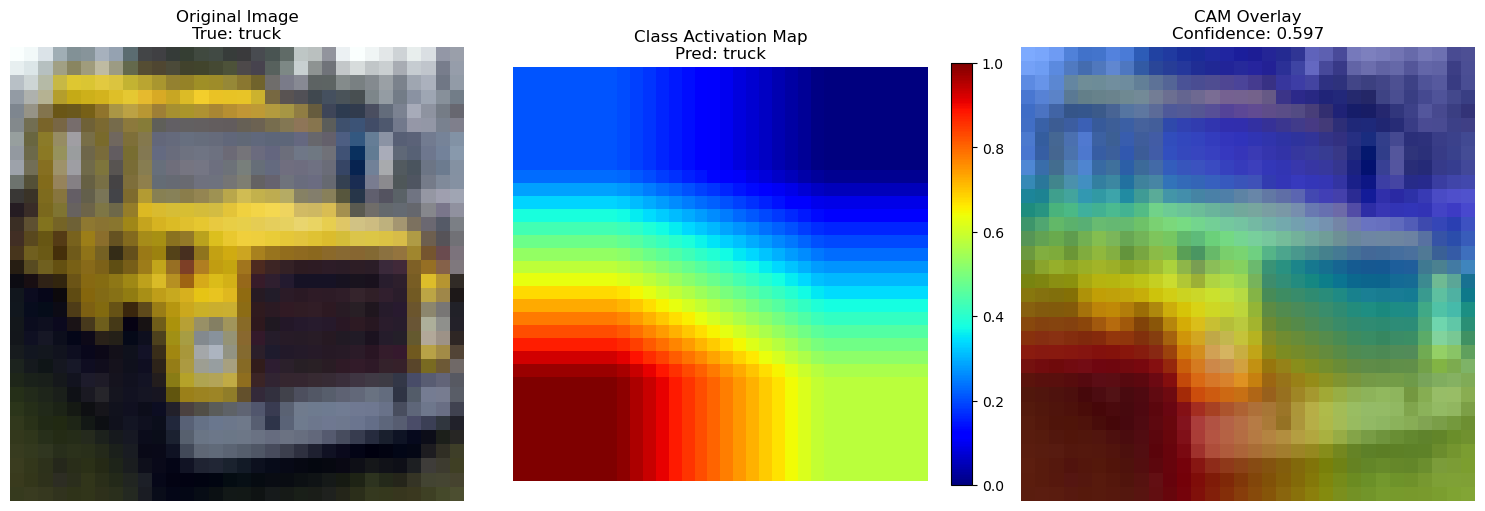


📊 CAM Statistics:
CAM shape: (32, 32)
CAM range: [0.0000, 1.0000]
CAM mean: 0.4464


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

CIFAR10_CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                      'dog', 'frog', 'horse', 'ship', 'truck']
# Carica immagine e modello
#image = CIFAR10(root='./data', train=False, download=True, transform=transform_cifar10)[0][0].unsqueeze(0)
dataset = CIFAR10(root='./data', train=False, download=True, transform=transform_cifar10)
image_idx = np.random.randint(0, len(dataset))  # Immagine casuale
image, true_label = dataset[image_idx]
image = image.unsqueeze(0).to(device)
print(f"Testing on image {image_idx}, true class: {CIFAR10_CLASSES[true_label]}")

# Carica il checkpoint salvato
checkpoint = torch.load('model_CNN_very_deep.pth')

# Ricrea il modello con la stessa architettura
model = My_Configurable_CNN(
    input_size=(32, 32),
    input_channels=3, 
    hidden_channels=checkpoint['hidden_channels'],
    num_classes=10
).to(device)

# Carica i pesi salvati
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Sposta immagine su device
image = image.to(device)

# Forward pass per ottenere predizioni e features
logits, features = model(image, return_cam=True)
predicted_class = logits.argmax(dim=1)
confidence = F.softmax(logits, dim=1)[0][predicted_class].item()
            
print(f"Predicted: {CIFAR10_CLASSES[predicted_class]} (confidence: {confidence:.3f})")
print(f"True label: {CIFAR10_CLASSES[true_label]}")

# Genera CAM
cam = model.get_cam(features, predicted_class)
cam = F.relu(cam)  # ReLU per evidenziare solo contributi positivi
cam = cam - cam.min()
cam = cam / cam.max()

# Ridimensiona CAM alle dimensioni dell'immagine originale
cam_resized = F.interpolate(
            cam.unsqueeze(1), 
            size=image.shape[2:], 
            mode='bilinear', 
            align_corners=False
        )

cam_results(image, cam_resized, predicted_class, true_label, confidence, CIFAR10_CLASSES)


In [36]:
import torchvision.models as models

class CAM_ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(CAM_ResNet18, self).__init__()
        
        # Carica ResNet-18 pretrainata
        resnet = models.resnet18(pretrained=True)
        
        # Estrai le features (tutto tranne avgpool e fc)
        self.features = nn.Sequential(*list(resnet.children())[:-2])
        
        # GAP e nuovo classificatore per Imagenette
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Linear(512, num_classes)  # ResNet-18 ha 512 features
        
        # Inizializza il nuovo classificatore
        nn.init.xavier_uniform_(self.classifier.weight)
        nn.init.zeros_(self.classifier.bias)
    
    def forward(self, x, return_cam=False):
        # Features da ResNet backbone
        features = self.features(x)  # [batch, 512, h, w]
        
        # GAP e classificazione
        pooled = self.gap(features)
        pooled = pooled.view(pooled.size(0), -1)
        logits = self.classifier(pooled)
        
        if return_cam:
            return logits, features
        return logits
    
    def get_cam(self, features, class_idx):
        """Genera CAM per una classe specifica"""
        weights = self.classifier.weight[class_idx].view(-1, 1, 1)
        cam = (weights * features).sum(dim=1)  # [batch, h, w]
        return cam

Testing on image 2455, true class: garbage truck
Predicted: church (confidence: 0.557)
True label: garbage truck


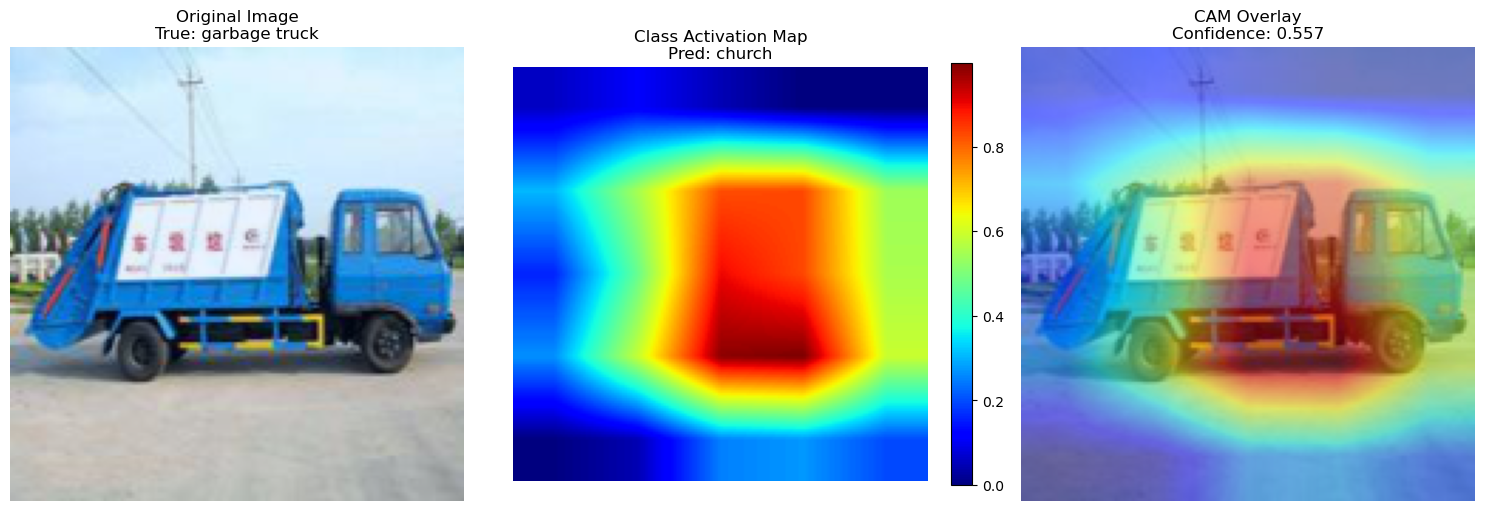


📊 CAM Statistics:
CAM shape: (160, 160)
CAM range: [0.0000, 0.9971]
CAM mean: 0.4155


In [45]:
from torchvision.datasets import Imagenette

transform_imagenette = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])

IMAGENETTE_CLASSES = [
        'tench', 'English springer', 'cassette player', 'chain saw', 'church',
        'French horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute'
    ]

dataset = Imagenette(root='./data', split='val', size='160px', 
                           download=False, transform=transform_imagenette)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

image_idx = np.random.randint(0, len(dataset))  # Immagine casuale
image, true_label = dataset[image_idx]
image = image.unsqueeze(0).to(device)
print(f"Testing on image {image_idx}, true class: {IMAGENETTE_CLASSES[true_label]}")

model = CAM_ResNet18(num_classes=len(IMAGENETTE_CLASSES)).to(device)
model.eval()
image = image.to(device)
# Forward pass per ottenere predizioni e features
logits, features = model(image, return_cam=True)
predicted_class = logits.argmax(dim=1)
confidence = F.softmax(logits, dim=1)[0][predicted_class].item()
            
print(f"Predicted: {IMAGENETTE_CLASSES[predicted_class]} (confidence: {confidence:.3f})")
print(f"True label: {IMAGENETTE_CLASSES[true_label]}")

# Genera CAM
cam = model.get_cam(features, predicted_class)
cam = F.relu(cam)  # ReLU per evidenziare solo contributi positivi
cam = cam - cam.min()
cam = cam / cam.max()

# Ridimensiona CAM alle dimensioni dell'immagine originale
cam_resized = F.interpolate(
            cam.unsqueeze(1), 
            size=image.shape[2:], 
            mode='bilinear', 
            align_corners=False
        )

cam_results(image, cam_resized, predicted_class, true_label, confidence,IMAGENETTE_CLASSES)